# QISKIT - Quantum representations implementation tutorial

During this tutorial, I will explain and implement some quantum encoding algorithms from ["Quantum image representation: a review"](https://www.researchgate.net/publication/366599323_Quantum_image_representation_a_review) article from Marina Lisnichenko and Stanislav Protasov.
All of the implemented code comes from the referenced Github in this article: [repository link](https://github.com/UralmashFox/QPI)

## Table of contents

- [Packages installation](#Packages-installation)
- [Libraries import](#Libraries-import)
- [Introduction](#Introduction)
    - [Registers](#Registers)
    - [Quantum circuit](#Quantum-circuit)
    - [Quantum gates](#Quantum-gates)
- [Representations](#Types-of-representation)
    - [Mixed representation](#Mixed-representation)
        - [Qubit Lattice](#Qubit-Lattice)
        - [FRQI](#FRQI---Flexible-representation-of-quantum-images)
        - [MCRQI](#MCRQI---Multi-channel-Representation-for-Images)
    - [Continous representation](#Continous-Representation-examples)
        - [QSMC_QSNC](#QSMC_QSNC)
        - [OQIM](#OQIM---Order-encoded-quantum-image-model)
    - [Discrete representation](#Discrete-representation-examples)
        - [NEQR](#NEQR---Novel-enhanced-quantum-representation-of-digital-images)
        - [BRQI](#BRQI---Quantum-image-representation-based-on-bitplanes)
        - [GQIR](#GQIR)

### Packages installation

For this tutorial, we will require the installation of this packages

In [ ]:
!pip install requirements.txt

 As a clarification, the used Qiskit version is outdated as of today, but it is needed for now because of all the changes that the functions suffered, making it impossible to adapt in some implementations. Likewise, the algorithms core concepts are inherently the same.

### Libraries import

All the dependencies we will need for the execution of the code.
The ibm_washington_config and ionq_config files are all available in the repository folder.

In [2]:
import math
from math import pi

import numpy as np

from utils import image_generate, plot_to_compare, calculate_mse

import qiskit
from qiskit.extensions import XGate
from qiskit import transpile, assemble
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import circuit_drawer
from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer, IBMQ, execute
from qiskit.circuit.library.standard_gates.ry import RYGate
from qiskit.tools.visualization import plot_bloch_multivector

import matplotlib.pyplot as plt

from ionq_config import coupling_map, basis_gates

from ibm_washington_config import coupling_map, basis_gates

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_13064\3857840592.py:9: DeprecationWarning: The qiskit.extensions module is deprecated since Qiskit 0.46.0. It will be removed in the Qiskit 1.0 release.
  from qiskit.extensions import XGate


 <hr style="border: 2px solid black;">

# Introduction

In this section, the main parts of a quantum image encoding algorithm will be deconstructed in detail, in order to facilitate the subsequent explanations.

As an starting point, we will see some of the important elements used by the different implementations.

### Registers

In order to work with quantum algorithms, it is needed to declare the number of qubits our circuits require.

In [5]:
QuantumReg = QuantumRegister(5, 'QReg') # 1st argument -> nº qubits; 2nd argument -> label
ClassicalReg = ClassicalRegister(5, 'ClReg')

### Quantum circuit

Quantum circuits are the backbone of quantum algorithms. They represent the main structure where the quantum data is represented, manipulated and converted into a classical representable result.

In [6]:
QC = QuantumCircuit(QuantumReg, ClassicalReg)

C:\Users\jfcoa\AppData\Roaming\Python\Python39\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


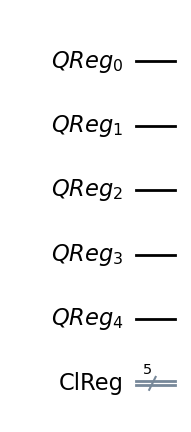

In [7]:
QC.draw(output='mpl')

### Quantum gates

Quantum logic gates are fundamental circuits that operate on qubits, similar to classical logic gates in digital circuits. They are described as unitary operators represented by unitary matrices relative to an orthonormal basis, typically the computational basis, which uses binary notation for labeling basis vectors.

In a practical context, they act directly with the qubit, rotating its angle in the bloch state matrix.

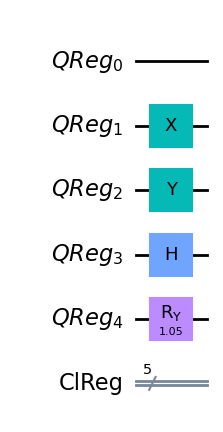

In [8]:
QC.x(1) # X-Gate -> argument corresponds to the target qubit
QC.y(2) # Y-Gate
QC.h(3) # Hadamard Gate
QC.ry(1.05,4) # RY-Gate -> 1st argument corresponds to the rotating angle
QC.draw(output='mpl')

To clarify, every qubit declared in a quantum circuit in Qiskit will have an initial local state of 0, as a matter of standard, because in reality the starting state of the input in the circuit isn't always determined, it could be a quantum state in a family of possible states. 

After that, we generate the results using a simulated quantum device.

In [9]:
result = execute(QC, Aer.get_backend('statevector_simulator')).result()

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_9388\3273368251.py:1: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  result = execute(QC, Aer.get_backend('statevector_simulator')).result()
C:\Users\jfcoa\AppData\Local\Temp\ipykernel_9388\3273368251.py:1: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(QC, Aer.get_backend('statevector_simulator')).result()


In [10]:
statevector = result.get_statevector()

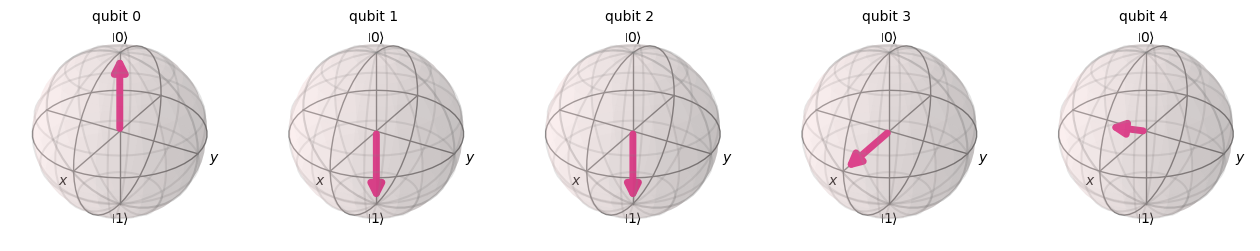

In [11]:
plot_bloch_multivector(statevector)

But how we represent this data?

Initally, qubits have two possible local states: 0 and 1; and these are represented in the bloch sphere shown before. For example, a qubit with local state 0 when we apply the X or the Y gate it rotates to local state 1.

In [12]:
QC = QuantumCircuit(1, 1)

In [13]:
QC.measure([0], [0])
counts = execute(QC, Aer.get_backend('aer_simulator'), shots = 100).result().get_counts()

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_9388\3286676961.py:2: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  counts = execute(QC, Aer.get_backend('aer_simulator'), shots = 100).result().get_counts()


Every time we look up to the results of a certain quantum machine, we look up to the counts, a parameter that contains all the states which were generated by the quantum system and how many times they were measured. This is important because a quantum computer works as a probability machine, the number of counts of each state compared to the total sum of counts equals to a probability value.

In [14]:
print(counts)

{'0': 100}


In this case, because we didn't use any gate to alterate the basis state of the qubit, every count has been in the local state of 0.

In [15]:
QC.x(0)

In [16]:
QC.measure([0], [0])
counts = execute(QC, Aer.get_backend('aer_simulator'), shots = 100).result().get_counts()
print(counts)

{'1': 100}


C:\Users\jfcoa\AppData\Local\Temp\ipykernel_9388\4027092522.py:2: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  counts = execute(QC, Aer.get_backend('aer_simulator'), shots = 100).result().get_counts()


Now, as we have said before, the X gate takes the basis state all the way to the 1 value. But, what happens if the apply an Ry or Rx gate?

In [17]:
QC.ry(1.25, 0)

In [18]:
QC.measure([0], [0])
counts = execute(QC, Aer.get_backend('aer_simulator'), shots = 100).result().get_counts()
print(counts)

{'0': 42, '1': 58}


C:\Users\jfcoa\AppData\Local\Temp\ipykernel_9388\4027092522.py:2: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  counts = execute(QC, Aer.get_backend('aer_simulator'), shots = 100).result().get_counts()


As we can see, the counts are now divided and corresponds to a probability of being in one of the two possible states.

If we look closely, when RY-Gate application is declared, it requires 2 values instead of 1, as the other gates. The reason is that this type of gate needs the user to specify the rotation value, so the parameter must be between 0 and $\pi$.

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_9388\921772064.py:6: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(QC, Aer.get_backend('statevector_simulator')).result()


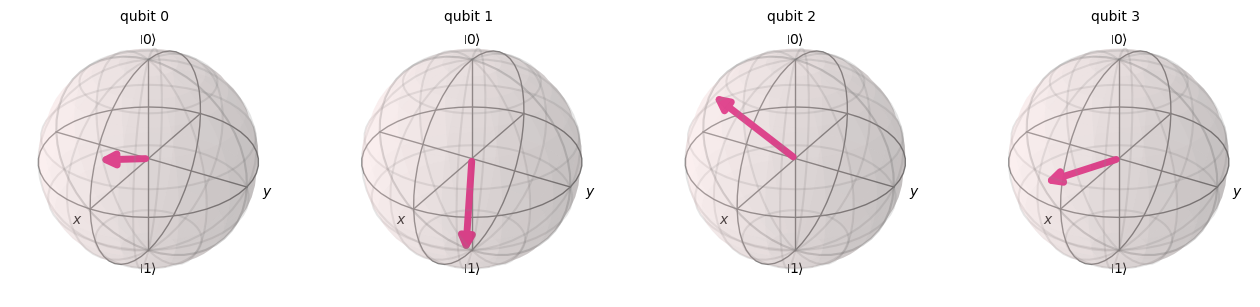

In [19]:
QC = QuantumCircuit(4, 4)
QC.ry(1.12, 0)
QC.ry(3.02, 1)
QC.rx(1.12, 2)
QC.rx(2.12, 3)
result = execute(QC, Aer.get_backend('statevector_simulator')).result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

Last, but not least, the Hadamard gate is also very important, because it will necessary in some algorithms to initialize the qubit into a superposition state, a state where all the qubit states are equal.

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_9388\44504658.py:3: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(QC, Aer.get_backend('statevector_simulator')).result()


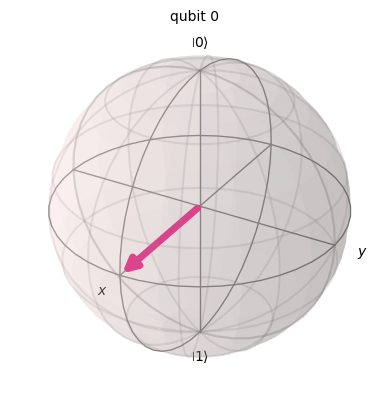

In [20]:
QC = QuantumCircuit(1, 1)
QC.h(0)
result = execute(QC, Aer.get_backend('statevector_simulator')).result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

In [21]:
QC.measure([0], [0])
counts = execute(QC, Aer.get_backend('aer_simulator'), shots = 100).result().get_counts()
print(counts)

{'0': 62, '1': 38}


C:\Users\jfcoa\AppData\Local\Temp\ipykernel_9388\4027092522.py:2: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  counts = execute(QC, Aer.get_backend('aer_simulator'), shots = 100).result().get_counts()


These are the most relevant properties to this project, because they will be used to treat the input quantum data, transform it, and generate the output classical data we want. 

 <hr style="border: 2px solid black;">

# Types of representation

In the field of quantum image embedding, there are four types of representations: 
- Mixed 
- Continuous 
- Discrete 
- Phase (Fourier Transformation)

Each one has its unique characteristics and complexity. Before we get started with them, I will summarize how they work and how they approach the image encoding process.

Continous representation: this representation allows to use a single qubit for pixel intensity and coordinate encoding, with the drawback of requiring multiple measurements to estimate high precision values.

Discrete representation: 

Mixed representation: methods where continuous encoding is used for the pixel intensity and the pixel location is represented discretely.  

During the next steps of this tutorial we will see this different groups, ordered by their complexity, and how they treat the data and are implemented.

# Mixed representation

 ## [Qubit Lattice](https://doi.org/10.1117/12.485960)

As an introduction to this topic, Qubit Lattice, a mixed representation algorithm, can help to understand some basic concepts, being one of the reasons the fact that, this application, doesn't use advanced quantum properties like entaglement or superposition, which will be seen as we proceed with the tutorial.

 ### Image generation 

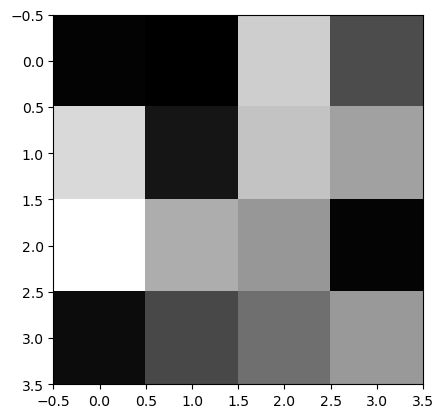

In [77]:
image = image_generate("small")
plt.imshow(image, cmap = 'gray')
signal = image.flatten() # this function reduces the dimensionality of the array, so we work with 1 dimension instead of 2
signal = np.interp(signal, (0, 255), (0, np.pi)) # converts the 0-255 value range of a grayscaled image into 0-pi range

It is necessary to transform the values into [0-$\pi$] range, because qubits use angles in order to rotate or represent the different pixel values.

### Quantum circuit building

In order to build the quantum circuit, we have to follow these steps:
1. Declare the qubits required for the input image (the number varies between algorithms).
2. Declare the classical bits required, the number corresponds to the same as of the qubits.
3. Create the quantum circuit.
4. Initialize the circuit, if its required.
5. Apply rotations to the different qubits using gates, corresponding to the applied algorithms theory.
6. Carry out the measurement to output our results in classical bits.

Regarding this algorithm, the qubits required are $2^{2n}$ for representing a $2^{n}$ x $2^{n}$ image.

In [78]:
# 1. Required qubits declaration
color = QuantumRegister(len(signal), 'color')

# 2. Classical bits declaration
classic = ClassicalRegister(color.size, 'classic')

# 3. Quantum circuit implementation 
qc = QuantumCircuit(color, classic)

# 4. In this example, the circuit initialization isn't required due to the simplicity of the circuit

# 5. Rotation gates application
for i, ang in enumerate(signal):
    qc.ry(ang, i) # RY-Gate application -> rotates the state along the Y-axis

# 6. Measurement 
qc.measure(list(reversed(range(len(signal)))), range(len(signal)))

The first input value in the measure function is reversed because the less significative bit is located in the first position of the qubit state array.

During comparisons between circuits, depth is a relevant factor because it represents the longest path in the circuit(the path length is always an integer number, representing the number of gates it has to execute in that path), which is important in the optimization field.

In [79]:
print("depth is {}, # of qubits is {}".format(qc.depth(), qc.num_qubits))

depth is 2, # of qubits is 16


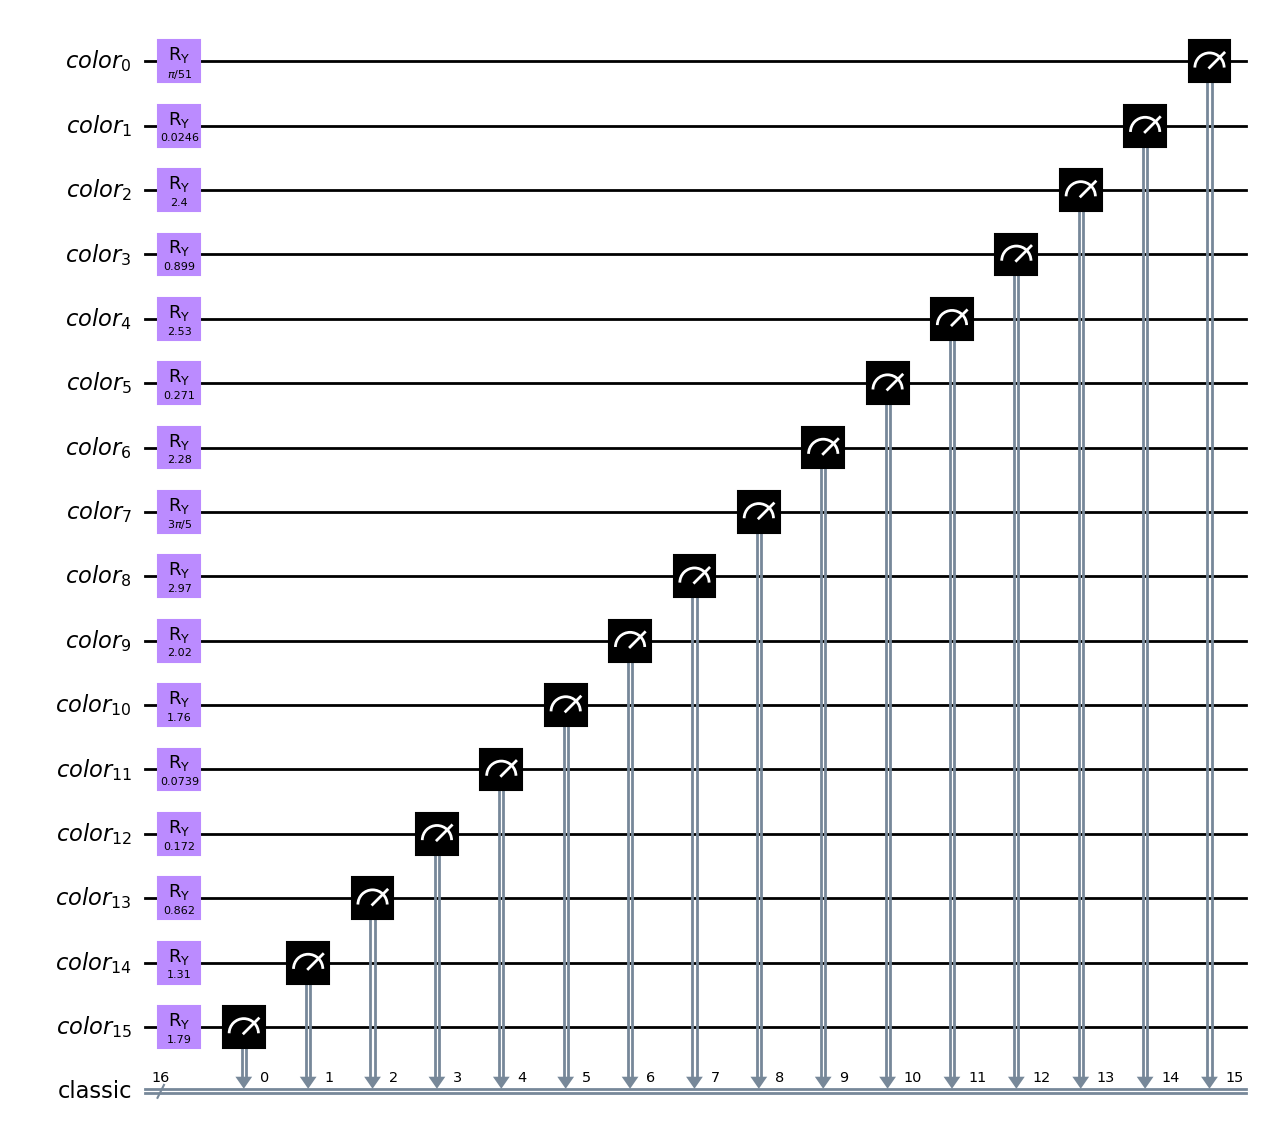

In [80]:
qc.draw('mpl')

In order to match the topology of an specific quantum device or/and optimize the circuit for execution on present day noisy quantum systems, it is required to rewrite the given input circuit. This process is called transpilation.

With this command you can visualize the transpiled quantum circuit, adapted to washington_qc quantum device.

In [81]:
wash_qc = transpile(circuits=qc, coupling_map=list(coupling_map)[0], basis_gates=basis_gates)
print("depth is {}".format(wash_qc.depth()))

depth is 2


In the following algorithms, this instruction won't be used due to the increase of quantum circuit lenght and depth, making the notebook unreadable, but it can be tested freely for everyone.

### Backend simulations

Backend are the responsibles of running the quantum circuits, simulating the different states and returning results.
During this tutorial we will use a backend simulator called "aer_simulator". Simulators are software applications that emulate the behaviour of real quantum devices, in order to debug and algorithms before using them in valuable quantum hardware, due to their costs. 

In [3]:
def backend_sim(qc, backend, shots):
    t_qc = transpile(qc, backend)
    qobj = assemble(t_qc, shots=shots)
    job = backend.run(qobj)
    result = job.result()
    counts = result.get_counts()
    return result, counts

In [141]:
counts_list = []
shots_list = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 1000000]
for shots in shots_list:
    backend = Aer.get_backend('aer_simulator')
    result, counts = backend_sim(qc, backend, shots)
    counts_list.append(counts)

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_9388\1756418184.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


In [142]:
mse_list = []
for i in range(1, len(counts_list)):
    mse = calculate_mse(counts_list[i-1], counts_list[i])
    mse_list.append(mse)

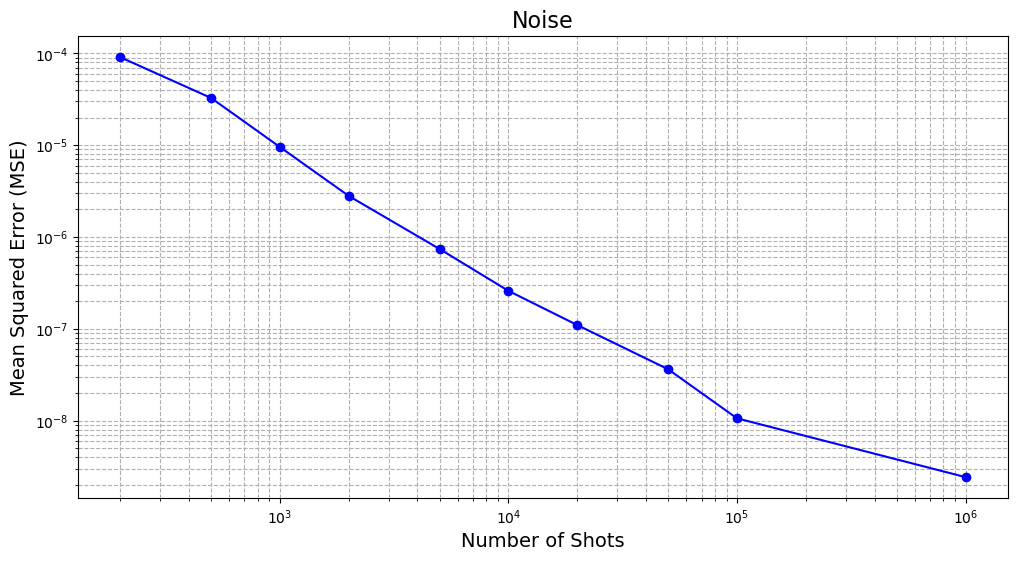

In [143]:
plt.figure(figsize=(12, 6))
plt.plot(shots_list[1:], mse_list, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Shots', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.title('Noise', fontsize=16)
plt.grid(True, which="both", ls="--")
plt.show()

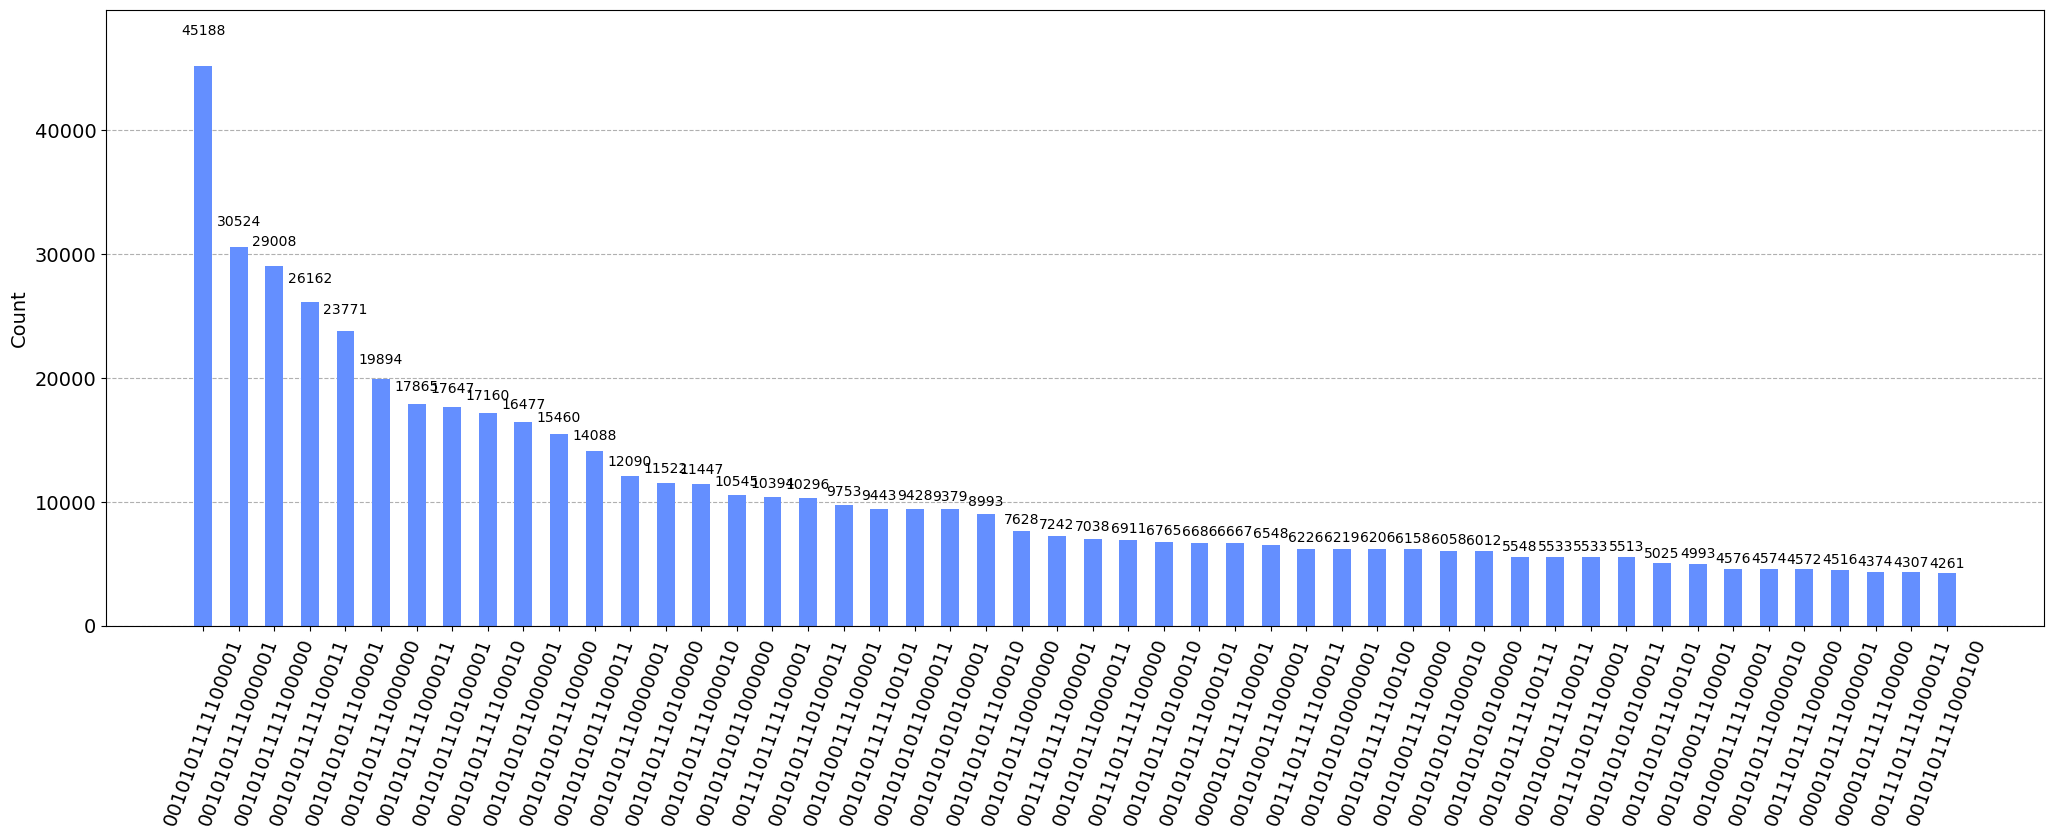

In [121]:
plot_histogram(counts, figsize=(25,8), sort="value_desc", number_to_keep=50)

And, now? How do we work with these values?

<img src="images/ruan_mei.webp" alt="drawing" width="200" style="float: left;"/>

### Results treatment

The results we have already seen in "counts" are the different qubit states equal to the result image color structure. The values 0 and 1 represent black and white(0 and 255), and the values in between are approximated to them. For example, if the color value of the pixel is 130 it will be translated as 1 when we analyze the result, because it is closer to the value in question.
The reason about this is that the rest of the information about the pixel color is stored in the probabilites obtained from the circuit. 


Let's analyze this more deeply...

In [92]:
pixels = np.zeros((len(signal)))
for item in counts:
    for i, bit in enumerate(item):
        if bit=='0':
            pixels[i]+=counts[item]

In [93]:
print(pixels)

[999063. 999846. 130914. 810887.  91987. 981623. 174409. 345499.   7599.
 283759. 406062. 998624. 992549. 825729. 631250. 392983.]


What we have done here is getting all the 255 values in every qubit state, and applying its count value (their probabilities) to a pixel array with the image size.

Now, in the next step we will translate this values into angles.

In [94]:
reconstruct = []
for pixel in pixels:
    color = 2*np.arccos((pixel/shots)**(1/2)) # "shots" corresponds to the total counts value.
    reconstruct.append(color)
print(reconstruct)

[0.0612304761592294, 0.02481998436603705, 2.401152949204924, 0.8997905786720929, 2.5252983439715675, 0.27196093765847507, 2.2799371979774845, 1.884939826175424, 2.9670266012253195, 2.0180400460388803, 1.7597955158790468, 0.07420597250640572, 0.17285346041132998, 0.8612917249188068, 1.3051841772246937, 1.7864991323588417]


And now that we have the values translated into angles, we have to convert them again into the [0-255] range of grayscale values.

In [95]:
reconstruct = list(np.interp(reconstruct, (0, np.pi), (0, 255)).astype(int))
reconstruct = np.reshape(reconstruct, (4,4))
print(reconstruct)

[[  4   2 194  73]
 [204  22 185 152]
 [240 163 142   6]
 [ 14  69 105 145]]


### Input and measured images comparison

Finally, we can see the final result!

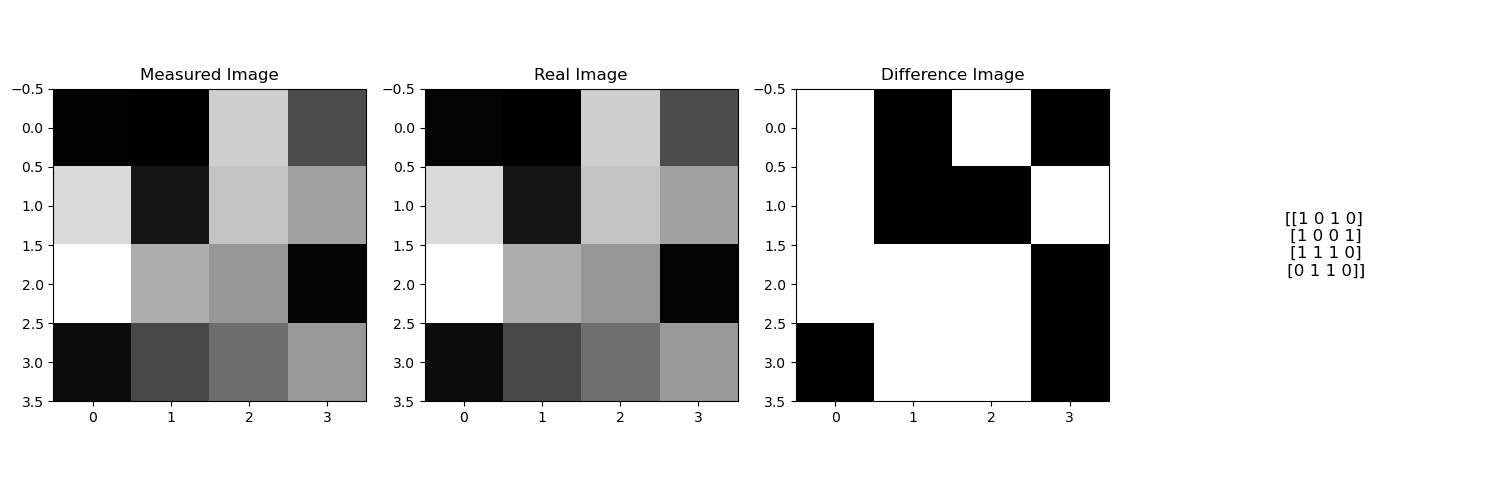

In [96]:
plot_to_compare(reconstruct, image)

How was it? Was it difficult? I hope that it wasn't because we are only getting started...

<div style="border-top: 2px dashed black;"></div>  

## Qubit Lattice 2.0

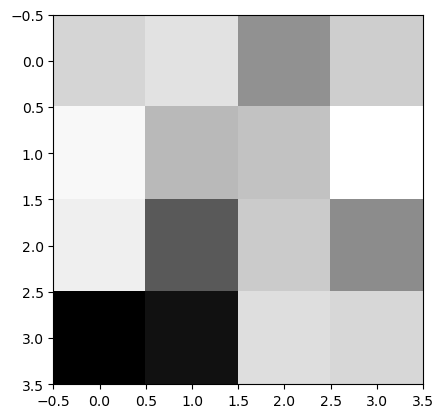

In [7]:
image = image_generate("small")
plt.imshow(image, cmap = 'gray')
signal = image.flatten() # this function reduces the dimensionality of the array, so we work with 1 dimension instead of 2
signal = np.interp(signal, (0, 255), (0, np.pi)) # converts the 0-255 value range of a grayscaled image into 0-pi range

In [10]:
# 1. Required qubits declaration
color = QuantumRegister(len(signal), 'color')

# 2. Classical bits declaration
classic = ClassicalRegister(color.size, 'classic')

# 3. Quantum circuit implementation 
qc = QuantumCircuit(color, classic)

# 4. In this example, the circuit initialization isn't required due to the simplicity of the circuit

# 5. Rotation gates application
for i, ang in enumerate(signal):
    qc.ry(ang, i) # RY-Gate application -> rotates the state along the Y-axis

observable = SparsePauliOp("Z" * len(signal))

In [12]:
backend = Aer.get_backend('aer_simulator')
estimator = Estimator()
circuits = [qc] * len(observable)

In [14]:
result = estimator.run(qc, observable)
print(result.result())
exp_vals = result.result().values

for i, exp_val in enumerate(exp_vals):
    print(f"Observable {i}: {exp_val}")

EstimatorResult(values=array([-0.00014858]), metadata=[{}])
Observable 0: -0.00014858429646047563


<div style="border-top: 2px dashed black;"></div>  

## [FRQI](https://link.springer.com/content/pdf/10.1007/s11128-010-0177-y.pdf) - Flexible representation of quantum images

The FRQI model follows the mixed representation method. It stores in a single qubit the color information for each pixel and uses its amplitude(control bits) for the coordinate values storage.

### Image generation

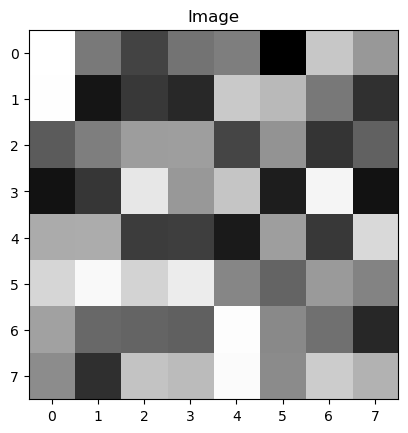

In [58]:
image = image_generate("normal")
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

### Image treatment and qubits calculation

Regarding this algorithm, the qubits required are $2n+1$ for representing a $2^{n}$ x $2^{n}$ image.

In [59]:
# Image flattening into 1D vector for convenience and simplicity.
input_im = image.copy().flatten()

# Transform the normalized values into angles
thetas = np.interp(input_im, (0, 255), (0, np.pi/2))

# Number of required qubits needed 
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

### Quantum circuit building

1. Initialize our qubits using the Hadamard gate to make them enter in a superposition state.
2. Create all possible qubit states.
3. Apply the required rotations.

The implementation of the FRQI needs to implement a $C^{n}(R_{y}(θ))$ gate for al the $2^{2n}$ pixels in the image. The way we do this is by changing the state of the pixel position qubits, for example, an image of $2\times2$ has 2 qubits, we have to change the states of those two qubits until we have gone through all the pixels in the image, i.e., "00000000", "01000010", "10100010", ..., "11111111". 

In [60]:
# Sets the qubits needed for the circuit
O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg') # target qubit

# Sets the bits that will hold the measurements result
cr = ClassicalRegister(O.size+c.size, "cl_reg")

# Creates the quantum circuit
qc = QuantumCircuit(c, O, cr)
num_qubits = qc.num_qubits

# Applies quantum gates to each initial qubit in the circuit
qc.h(O) # h -> Hadamard gate

For this algorithm, we have to declare a target qubit, which will be required for the following steps.

Now, we apply the Hadamard gate to each qubit to reach the superposition state.

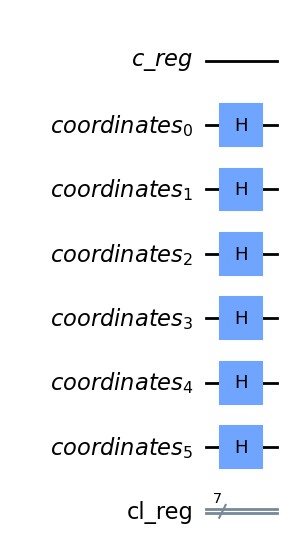

In [61]:
qc.draw('mpl')

In [62]:
controls = []
for i, _ in enumerate(O):
    controls.extend([O[i]]) # Store the no-target qubits (also named controls)

In [63]:
print(controls)

[Qubit(QuantumRegister(6, 'coordinates'), 0), Qubit(QuantumRegister(6, 'coordinates'), 1), Qubit(QuantumRegister(6, 'coordinates'), 2), Qubit(QuantumRegister(6, 'coordinates'), 3), Qubit(QuantumRegister(6, 'coordinates'), 4), Qubit(QuantumRegister(6, 'coordinates'), 5)]


In [64]:
for i, theta in enumerate(thetas):
    # Generate the different possible states of our qubits
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc.x(O[k]) # Apply X-gate to qubits in state '1'
    qc.barrier()
    
    # Applies the Ry multi-controlled gate to all the circuit qubits
    qc.mcry(theta=2*theta,
                  q_controls=controls,
                  q_target=c[0])
    
    qc.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc.x(O[k]) # Again, we apply X-gate to qubits in state '1'
    qc.barrier()

qc.measure(list(reversed(range(qc.num_qubits))), list(range(cr.size)))

The multi-controlled RY works in a different way as the other gates we have seen. Summing up in a few words, it applies a rotation in the target qubit whenever the other qubits basis state are equal to 1. This situation is produced thanks to the application of the X gate.

According to this, the color value is stored in the target qubit when we apply this algorithm.

In [65]:
print("depth is {}, # of qubits is {}".format(qc.depth(), qc.num_qubits))

depth is 640, # of qubits is 7


In [66]:
# qc.draw('mpl')

### Backend simulation

In [67]:
counts_list = []
shots_list = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 1000000]
for shots in shots_list:
    backend = Aer.get_backend('aer_simulator')
    result, counts = backend_sim(qc, backend, shots)
    counts_list.append(counts)

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_10236\1756418184.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


In [80]:
mse_list = []
for i in range(1, len(counts_list)):
    mse = calculate_mse(counts_list[i-1], counts_list[i])
    mse_list.append(mse)

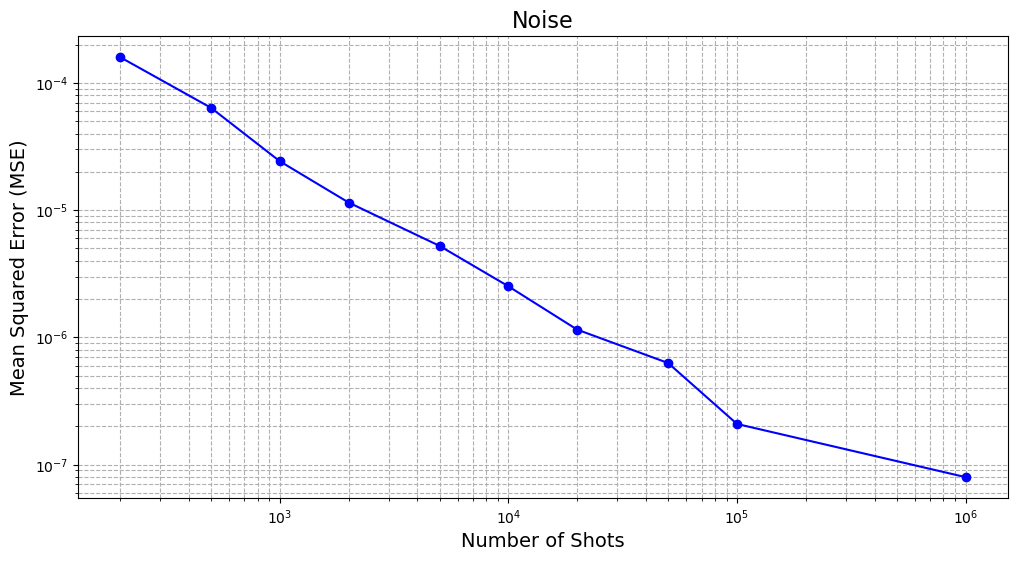

In [81]:
plt.figure(figsize=(12, 6))
plt.plot(shots_list[1:], mse_list, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Shots', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.title('Noise', fontsize=16)
plt.grid(True, which="both", ls="--")
plt.show()

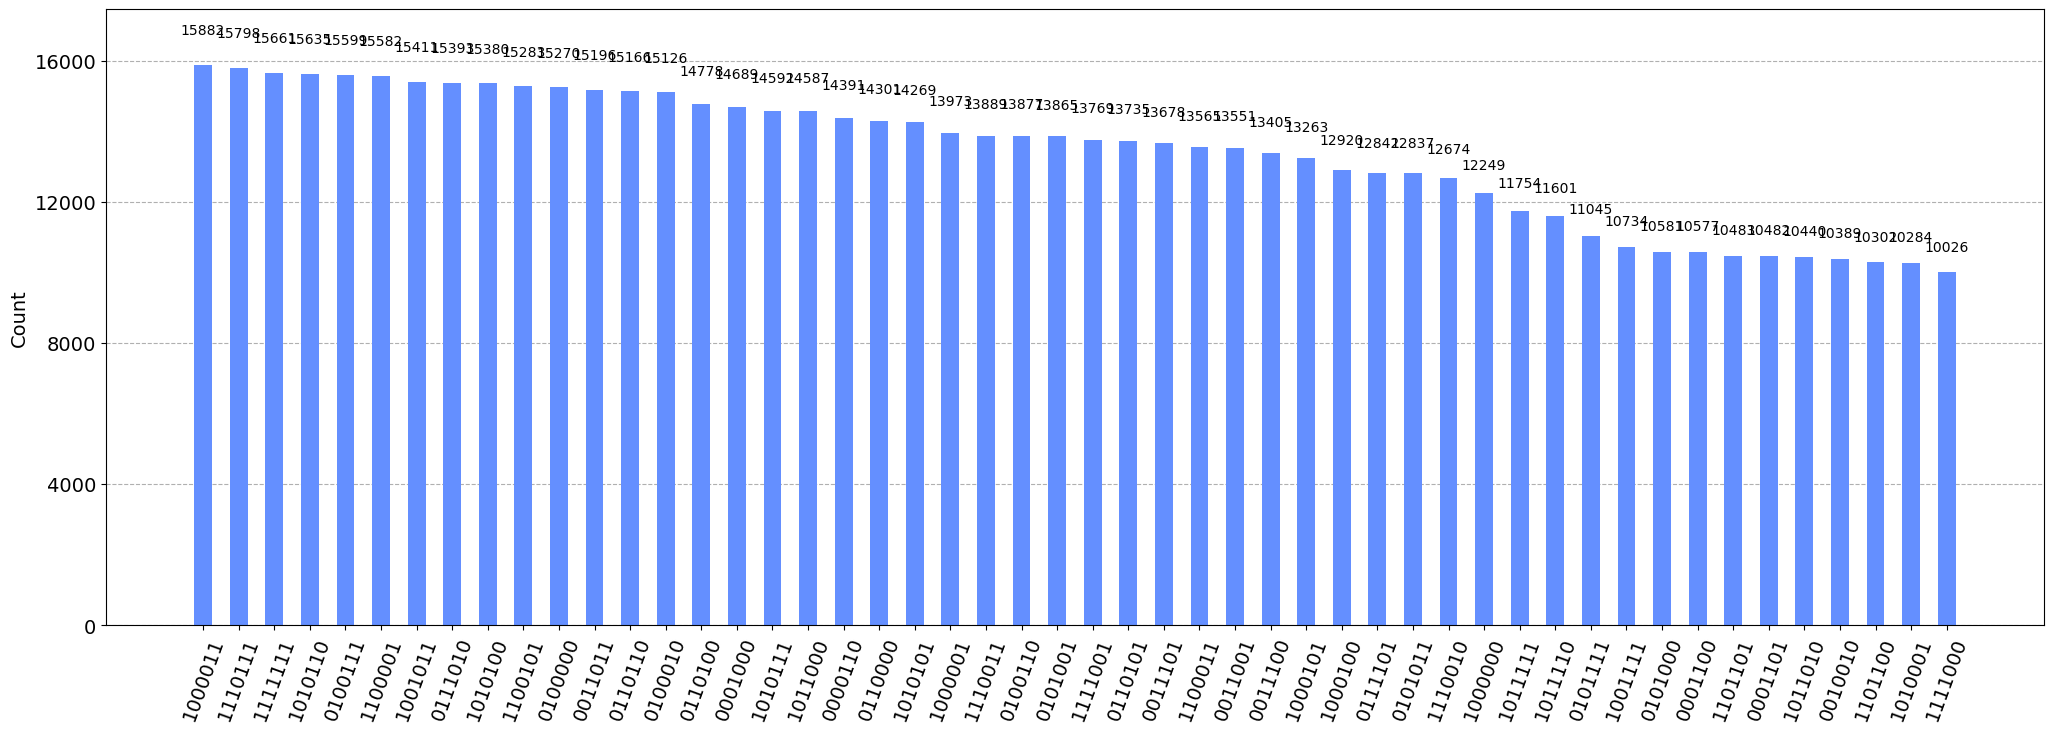

In [70]:
plot_histogram(counts, figsize=(25,8), sort="value_desc", number_to_keep=50)

### Results treatment

This representation uses the control bits to express the coordinate value, and the target to express the color value as we previously said. But, in terms of data transformation, after we apply all the circuit gates, the result will be treated the same way as Qubitt Lattice, using the sum of the shots value of each coordinate as a probability when the target is equal to 0.

In [71]:
classical_colors = []
for i in range(0, len(input_im)): # loop of every pixel in the image
    color_list = []
    for item in counts.items():
        key = item[0] # qubit state. Ex: 0001100
        amount = item[1] # count value
        bin_coord = key[1:] # coordinate -> qubit state without first bit(target)
        int_coord = int(bin_coord, 2) # coordinate value (decimal)
        if int_coord == i: # coordinate value == pixel coordinate
            color_list.append((key[0], amount)) # add [target/color bit, count value]
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
print(classical_colors)

[1.0905444856761572, 1.240269375001866, 0.8622947779749449, 1.5311420815533212, 1.13312843566845, 1.1933195429995476, 0.30091477023021185, 0.8606334538755702, 0.25215227646343574, 0.697286931140742, 0.8490110443358085, 1.538586057851946, 0.6028803962656282, 0.6210461245762539, 0.645793531259468, 0.9798421772590242, 0.8106465925392018, 0.9398861100156244, 0.6203159465897562, 0.8285607053377094, 1.4279830156763451, 1.2944114036277174, 1.5126397301924743, 1.3049370056126046, 1.3269417251167082, 0.3602665897105275, 0.9666950648491525, 0.1773208405917768, 0.3864849890335232, 0.3740095475278667, 1.0526230860664814, 1.0486934241636496, 0.13879923768627478, 1.491656801832486, 0.19960047573639414, 1.2056889674014288, 0.925065914145166, 1.4023460845691307, 0.3499954711502679, 0.12765857133659705, 0.6078256186246671, 0.33274714132364125, 0.9068618201303206, 0.43507301439893364, 0.9632514778360369, 0.9594158096908779, 0.7796568094407317, 0.5669433872539268, 0.3056634815853243, 0.7383351214322162, 

In [72]:
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 255)).astype(int)))
print(classical_colors)

[252, 121, 69, 113, 126, 3, 197, 150, 250, 24, 57, 42, 199, 183, 119, 49, 92, 126, 155, 156, 70, 147, 54, 98, 20, 56, 227, 150, 195, 32, 242, 22, 170, 170, 60, 62, 28, 156, 58, 215, 211, 245, 210, 231, 134, 100, 152, 131, 159, 104, 100, 97, 249, 137, 113, 40, 139, 48, 193, 183, 248, 139, 201, 177]


### Input and measured images comparison

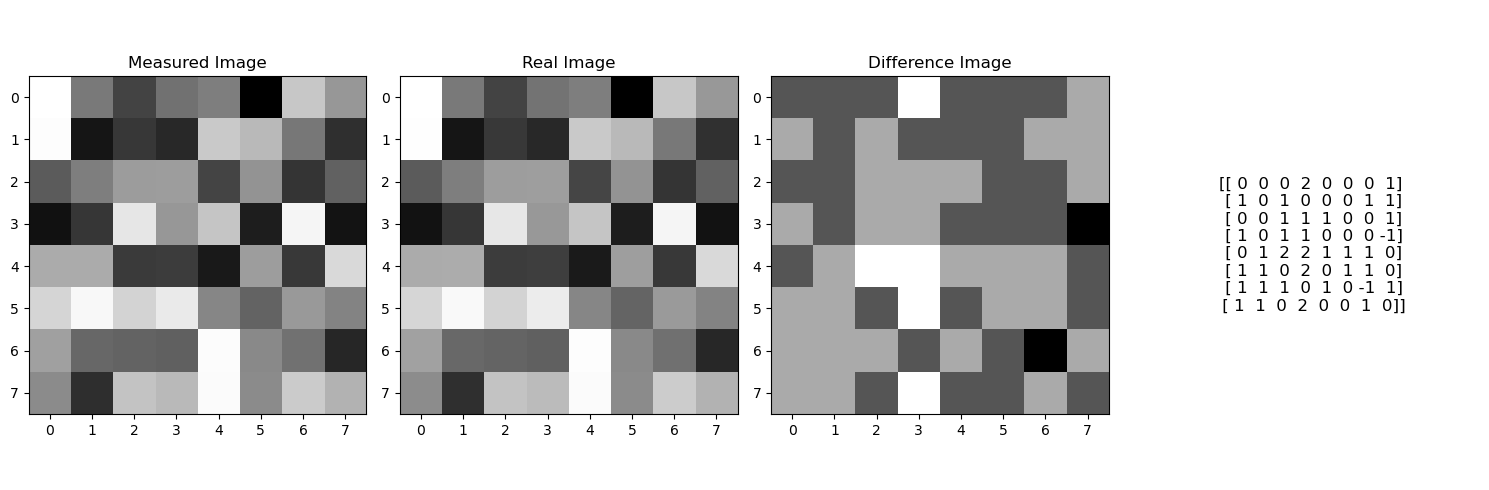

In [73]:
plot_to_compare(np.array(classical_colors).reshape(image.shape), image)

Okay, that's cool, but what if we add some color to this...

<img src="images/gray.png" alt="drawing" width="200" style="float: left;"/>

<div style="border-top: 2px dashed black;"></div> 

## [MCRQI](https://www.overleaf.com/project/61911febed45e965f929d7c0#cite.sun2011multi) - Multi-channel Representation for Images

The MCQI representation is a color image oriented model that uses FRQI implementation model as a base. The main differences between these models lie in the quantity of qubits needed to encode the intensities, because MCQI carries a multi-channel color representation method, and as a consequence, the quantity of measurements required to obtain the output image results.

### Image generation

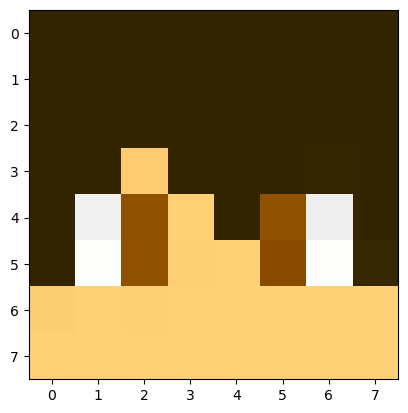

In [140]:
image = plt.imread('demo.jpg')
plt.imshow(image)
plt.show()

### Qubits calculation

Regarding this algorithm, the qubits required are $2n+3$ for representing a $2^{n}$ x $2^{n}$ image. There are 2 more qubits required in this algorithm because of the 3 color channels(R,G,B), unlike the FRQI that only uses 1 because it only applies with grayscale images.

In [141]:
xqbits = math.log(image.shape[0],2)
yqbits = math.log(image.shape[1],2)
coord_qbits = int(xqbits) + int(yqbits)

For the calculation of the number of qubits required, we can't flatten the image this time because we are working with three dimensions, and the data could be unreadable at the end of the algorithm.

### Quantum circuit building

In [142]:
qr = QuantumRegister(coord_qbits + 3)
cr = ClassicalRegister(coord_qbits + 3, 'c')
qc = QuantumCircuit(qr, cr)

We are applying a swap instruction, in order to work with transposed images.

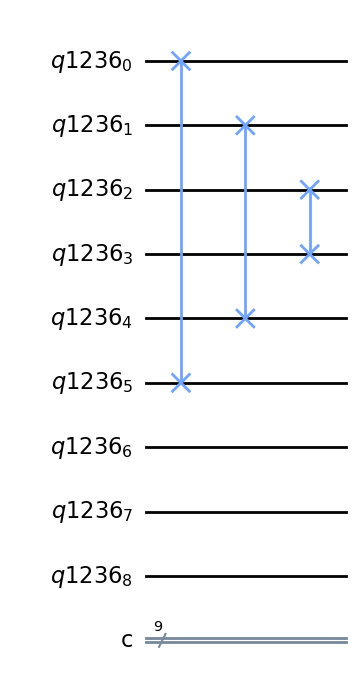

In [143]:
for k in range(int(np.floor(coord_qbits/2))):
    qc.swap(k,coord_qbits - 1 - k)
qc.draw('mpl')

Now, we apply the Hadamard gate to reach the superposition state.

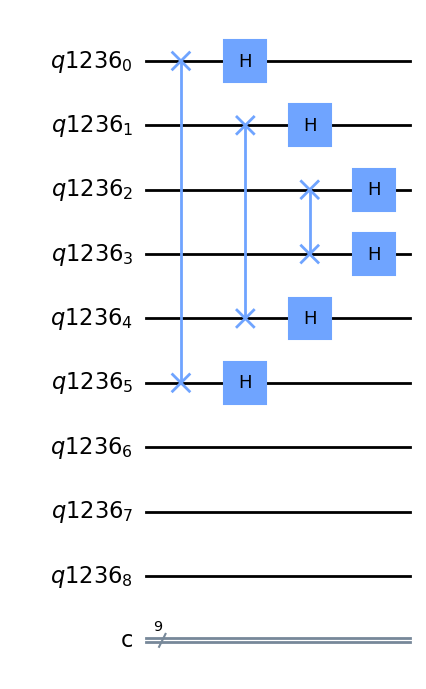

In [144]:
for i in range(coord_qbits):
    qc.h(i)
qc.draw('mpl')

In general terms, this representation follows the same implementation structure as the FRQI, but applied three times, one for each color channel.

The main difference is the target qubit. It will vary between qubit n+1, n+2 and n+3 depending on the layer that is currently being iterated.

In [145]:
for layer_num, input_im in enumerate(image.T): # loop for iterating R,G,B channels
    input_im = input_im.flatten() # flatten the image to 1-D
    input_im = np.interp(input_im, (0, 255), (0, np.pi/2)) # convert the color value into angles

    for i, pixel in enumerate(input_im):
        arr = list(range(coord_qbits)) # control qubits
        arr.append(int(coord_qbits + layer_num)) # target qubit application
        cMry = RYGate(2*pixel).control(coord_qbits) # create MCRY 

        to_not = "{0:b}".format(i).zfill(coord_qbits) # each possible state
        for j, bit in enumerate(to_not):
            if int(bit): # if bit == 1
                qc.x(j)
        qc.barrier()
        qc.append(cMry, arr) # apply MCRY

        if i!=len(input_im)-1 or layer_num!=2:
            for j, bit in enumerate(to_not):
                if int(bit):
                    qc.x(j)
            qc.barrier()

Now that we applied the required gates, we have to restablish the values to its corresponding qubit, swapping back.

In [146]:
for k in range(int(np.floor(coord_qbits/2))):
    qc.swap(k, coord_qbits - 1 - k)
    qc.barrier()

In [147]:
qc.swap(-1, -3)
qc.barrier()

In [148]:
# qc.draw('mpl')

In [149]:
for i in range(coord_qbits + 3):
    qc.measure(i, i)

In [150]:
print("depth is {}, # of qubits is {}".format(qc.depth(), qc.num_qubits))

depth is 576, # of qubits is 9


### Backend simulation

In [151]:
shots = 1000
backend = Aer.get_backend('aer_simulator')
result, counts = backend_sim(qc, backend, shots)

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_15108\1756418184.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


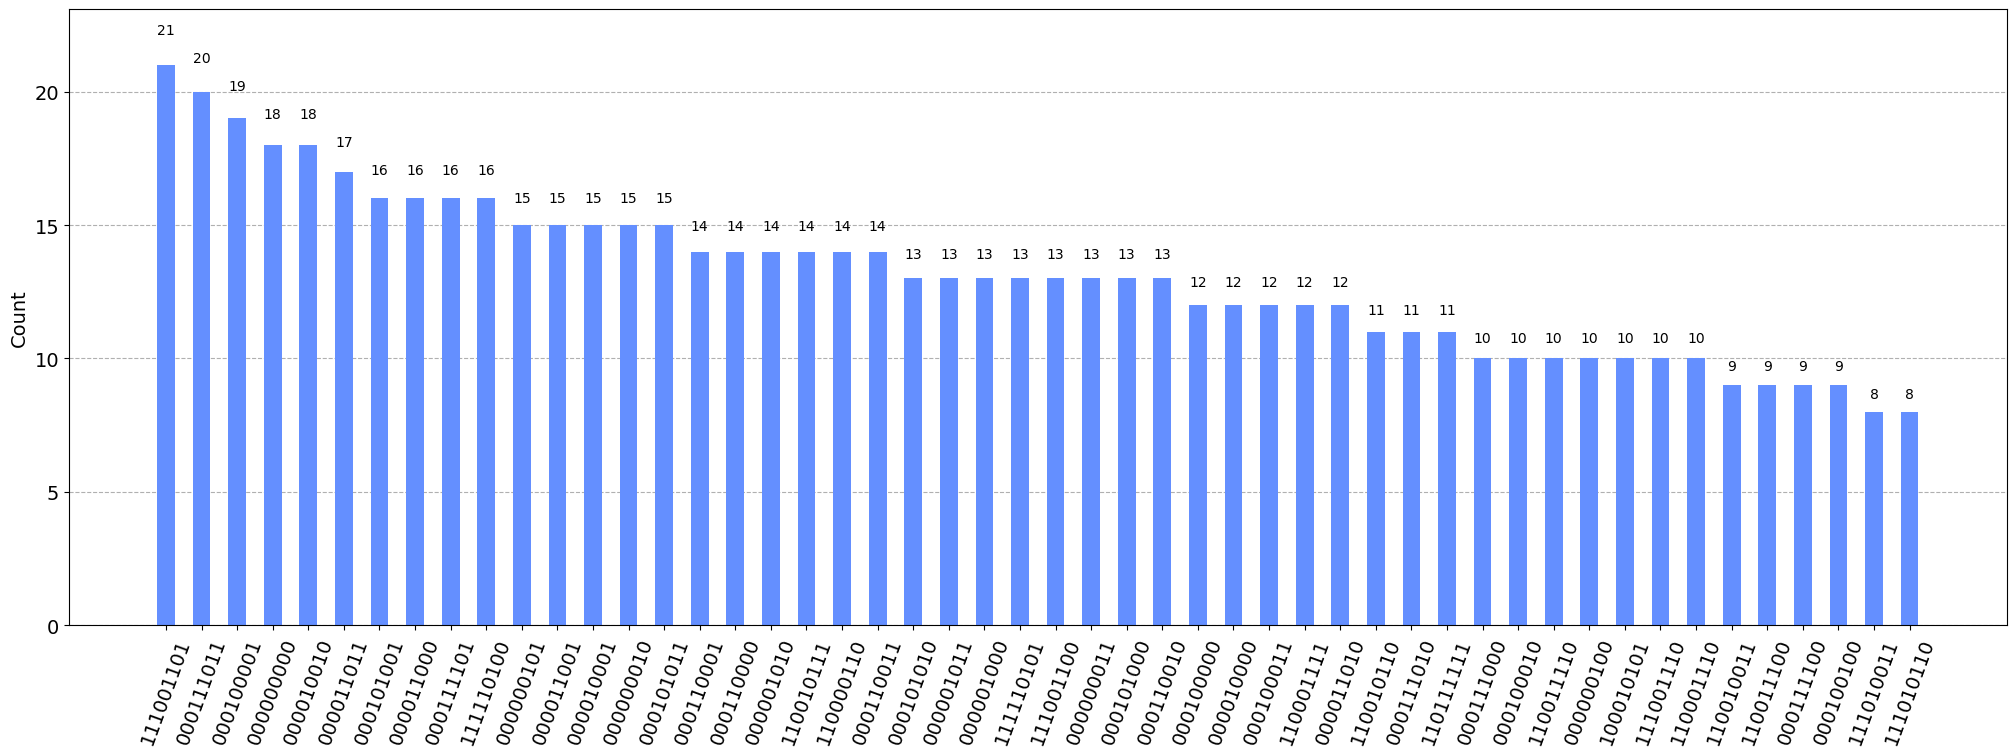

In [152]:
plot_histogram(counts, figsize=(25,8), sort="value_desc", number_to_keep=50)

### Results treatment

In this section, we can see some other differences in the final treatmeant and transformation of the image values.
The color values in a same pixel can be 0 and 1 this time, so the color value will be a calculation of the amount or probability of 0 respect the total of 0 and 1 counts.
The other characteristics stay the same, like the coordinates being in the n latest positions, and the final reconversion to grayscale values.

In [153]:
def reconstruct_rgb(image, counts):
    output_ims = []
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        nums = []
        for iter in range(len(input_im)): # every pixel iteration
            flag = 0
            num = []
            for item in counts.items():
                if int(item[0][3:], 2)==iter: # compare coordinate to pixel position
                    num.append((int(item[0][layer_num], 2), item[1])) # add [color, counts]
            nums.append(num)
        print("Counts matrix " + str(layer_num) + "\n", nums, "\n") # matrix with colors and probabilities
        for l, num in enumerate(nums):
            my_set = {x[0] for x in num} # every different color in pixel
            nums[l] = [(i,sum(x[1] for x in num if x[0] == i)) for i in my_set] # sum of same color values
        colors = []
        for num in nums:
            if len(num)==2:
                if num[0][0] == 0: # color value compared to total value calculation
                    color = np.arccos((num[0][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
                else:
                    color = np.arccos((num[1][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
            else:
                if num[0][0] == 0:
                    colors.append(0)
                else:
                    colors.append(np.pi/2) 
        print("Colors matrix " + str(layer_num) + "\n", colors, "\n")
        output_im = np.interp(colors, (0, np.pi/2), (0, 255)).astype(int)
        output_ims.append(output_im.reshape(image[:,:,0].shape))
    return np.array(output_ims).T
output_ims = reconstruct_rgb(image, counts)

Counts matrix 0
 [[(0, 18), (0, 1)], [(0, 7)], [(0, 15), (0, 1), (1, 2)], [(0, 13), (0, 1), (1, 1)], [(0, 10), (1, 2), (0, 1)], [(1, 3), (0, 15), (0, 2)], [(1, 14), (1, 8), (1, 1)], [(1, 2), (1, 3), (1, 7), (1, 1)], [(1, 4), (0, 13)], [(0, 8), (0, 1), (1, 2)], [(1, 1), (0, 14)], [(0, 13), (0, 1)], [(1, 13)], [(1, 21)], [(1, 10), (1, 10), (1, 2)], [(1, 6), (1, 12), (1, 1)], [(0, 12), (0, 1), (1, 4)], [(0, 15)], [(1, 2), (0, 18)], [(1, 1), (1, 8), (1, 9)], [(1, 3), (1, 5), (0, 4), (0, 3)], [(0, 4), (1, 10), (1, 3), (0, 2)], [(1, 1), (1, 1), (1, 11), (1, 8)], [(1, 14), (1, 7)], [(0, 16), (1, 1)], [(1, 1), (0, 15), (0, 1)], [(0, 12), (1, 2)], [(0, 17)], [(1, 9), (1, 7), (1, 1)], [(1, 1), (1, 6), (1, 5), (1, 1)], [(1, 6), (1, 1), (1, 10)], [(1, 6), (1, 8)], [(0, 12), (1, 1)], [(0, 19), (0, 1), (1, 1)], [(0, 10), (0, 1)], [(0, 12), (0, 2), (1, 2)], [(0, 9), (1, 2)], [(1, 4), (1, 4)], [(1, 7), (1, 8), (1, 1)], [(1, 8), (1, 6), (1, 1)], [(0, 13), (1, 1)], [(0, 16), (1, 1)], [(0, 13), (1, 2), (

In this examples, we can see how the data is being storaged during the transformation. For the "Counts matrices", they are formed by the different possible colors, and its corresponding counts values, from each layer pixels; as for the "Colors matrices", they are the result of the calculation of the final color value of all the pixel layers.

### Input and measured images comparison

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\jfcoa\AppData\Local\Temp\ipykernel_15108\2974149675.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


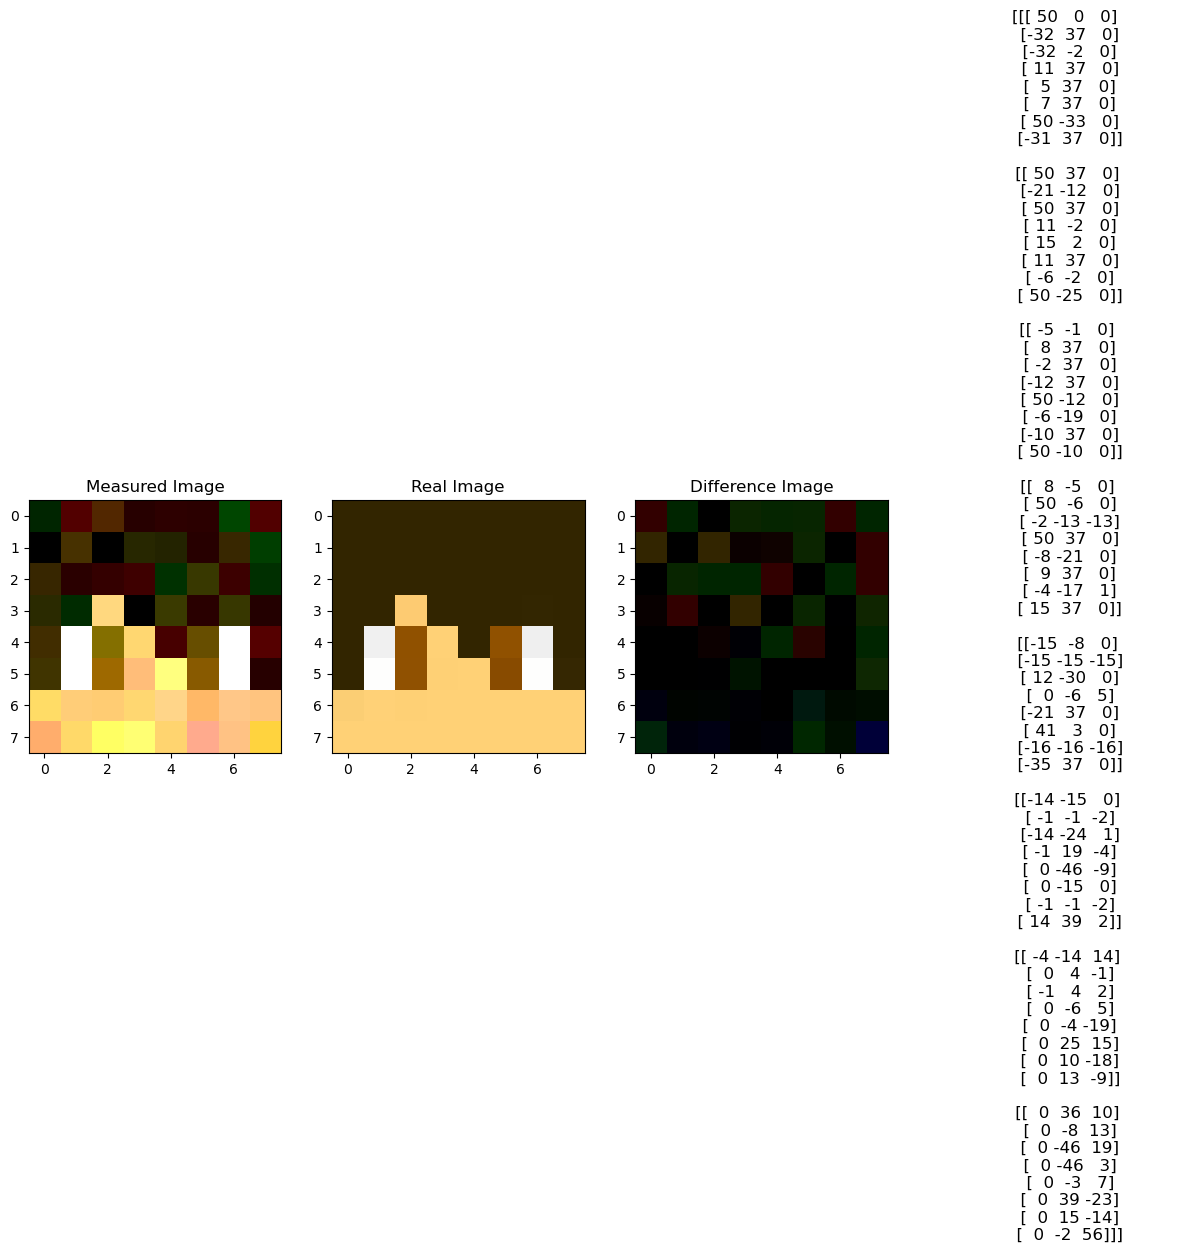

In [154]:
plot_to_compare(output_ims, image)

 <hr style="border: 2px solid black;">

# Continous Representation examples

## [QSMC_QSNC](https://www.researchgate.net/publication/257641707_Image_storage_retrieval_compression_and_segmentation_in_a_quantum_system)

The QSMC and QSNC model is a bijective model that splits the encoding process in three
different parts:
- QSMC: represents each color in an image using N 1-state qubits, being N the number of colors in the image.
- QSNC: represents the coordinates in an image using 1-state qubits.
- Image storing

### Image generation

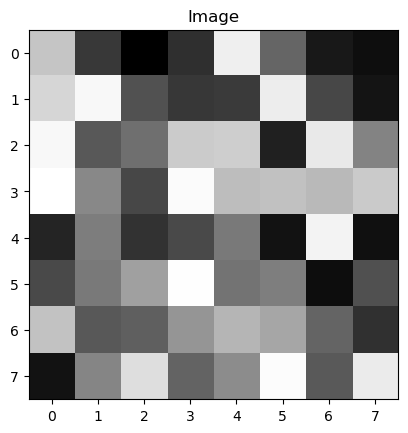

In [155]:
image = image_generate("normal")
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

### Qubits calculation

In [156]:
w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

For this implementation, we divide the angle matrices into 2, one for the color/intensity values and other for the coordinates.

The intensity matrix follows the same structure as the previous algorithms, transforming the color values into the [0-$\pi$] range. This matrix represents the QSMC part.

The coordinates matrix is formed by the different indexes of the images scaled and transformed into angles in the [0-$\pi$/2] range. This matrix represents the QSNC part.

In [157]:
im_list = image.flatten()
thetas = np.interp(im_list, (0, 255), (0, np.pi/2))
print(thetas)
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))
print(phis)

[1.20735718 0.35727916 0.01231997 0.30183929 1.46607657 0.62831853
 0.16015963 0.09855977 1.31207693 1.52151644 0.50511882 0.35111918
 0.36959914 1.4537566  0.44351896 0.13551968 1.52151644 0.54823872
 0.68991839 1.24431709 1.26279705 0.2155995  1.42911666 0.80695811
 1.56463634 0.83775804 0.44351896 1.5399964  1.16423728 1.18271723
 1.13959734 1.2381571  0.23407945 0.77615819 0.32031925 0.46199892
 0.75151824 0.12319971 1.49071651 0.11087974 0.45583893 0.75767823
 0.9855977  1.55847636 0.71455833 0.78231817 0.09239978 0.49895883
 1.18887722 0.54823872 0.59135862 0.91783785 1.11495739 1.02255761
 0.62215855 0.30799928 0.12319971 0.81927808 1.36135682 0.61599856
 0.86239798 1.54615638 0.56055869 1.44143663]
[0.         0.02454369 0.04908739 0.07363108 0.09817477 0.12271846
 0.14726216 0.17180585 0.19634954 0.22089323 0.24543693 0.26998062
 0.29452431 0.319068   0.3436117  0.36815539 0.39269908 0.41724277
 0.44178647 0.46633016 0.49087385 0.51541754 0.53996124 0.56450493
 0.58904862 0.61

In [158]:
num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1
print(num_ind_bits)

6


### Quantum circuit building

For the building of this circuit, we will require $2n + 2$ qubits for a $2^{n}$ x $2^{n}$ image. The added 2 qubits are used for the intensity and coordinate value storage, meanwhile the 2n qubits are used for indexing the qubit registers, the same as the other algorithms.

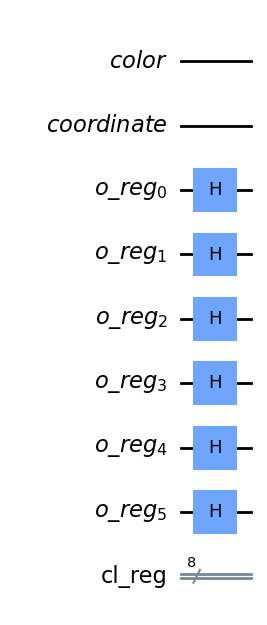

In [159]:
O = QuantumRegister(num_ind_bits, 'o_reg')
color = QuantumRegister(1,'color')
coordinate = QuantumRegister(1, 'coordinate')
cr = ClassicalRegister(O.size+color.size+coordinate.size, "cl_reg")

qc = QuantumCircuit(color, coordinate, O, cr)
# qc.i(color)
# qc.i(coordinate)
qc.h(O)
qc.draw('mpl')

In [160]:
controls = []
for i, _ in enumerate(O):
    controls.extend([O[i]])
print(controls)

[Qubit(QuantumRegister(6, 'o_reg'), 0), Qubit(QuantumRegister(6, 'o_reg'), 1), Qubit(QuantumRegister(6, 'o_reg'), 2), Qubit(QuantumRegister(6, 'o_reg'), 3), Qubit(QuantumRegister(6, 'o_reg'), 4), Qubit(QuantumRegister(6, 'o_reg'), 5)]


Regarding the quantum gates application, we apply the X gates when a bit of the state is equal to 1, being this process equal to what we have seen before, but with one little difference. 
The MCRY gate is now applied to different targets, and its angle values differs one from the other, the intensity target rotate depending on color matrix values (thetas) and coordinate target rotate depending on coordinate matrix values (phi).

In [161]:
for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc.x(O[k])
            
    qc.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns: # if intensity -> value == 0
            qc.mcry(theta=2*theta,
                          q_controls=controls,
                          q_target=color[0]) # mcry application to color target
        else: # if coordinate -> value == 1
            qc.mcry(theta=2*phi,
                          q_controls=controls,
                          q_target=coordinate[0]) # mcry application to coordinate target
       
    qc.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc.x(O[k])
                
    qc.barrier()

In [162]:
qc.measure(list(reversed(range(qc.num_qubits))), list(range(cr.size)))

In [163]:
print("depth is {}, # of qubits is {}".format(qc.depth(), qc.num_qubits))

depth is 1087, # of qubits is 8


In [164]:
# qc.draw('mpl')

### Backend simulation

In [165]:
shots = 100000000
backend = Aer.get_backend('aer_simulator')
result, counts = backend_sim(qc, backend, shots)

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_15108\1756418184.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


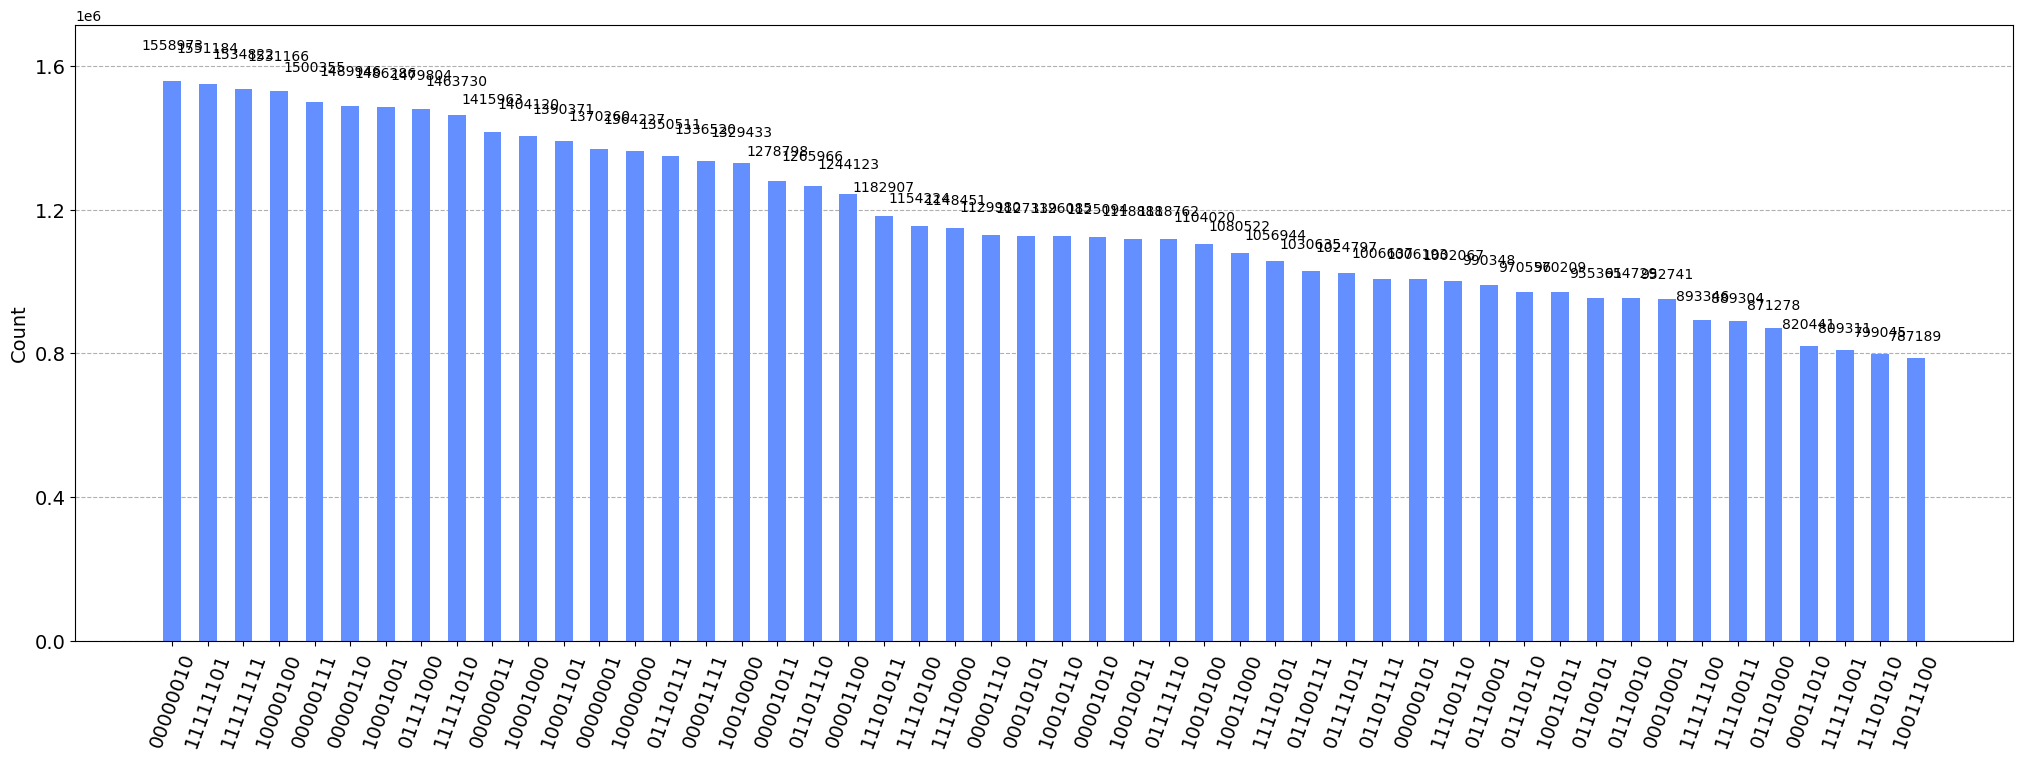

In [166]:
plot_histogram(counts, figsize=(25,8), sort="value_desc", number_to_keep=50)

### Results treatment

In [167]:
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k]) # ordered by 0 > 255
max_index = max(ind_list)
print(ind_list)

[2, 46, 7, 39, 37, 56, 15, 6, 21, 32, 3, 55, 34, 11, 1, 12, 14, 26, 40, 35, 47, 10, 17, 49, 62, 50, 59, 54, 5, 18, 44, 36, 41, 33, 45, 23, 57, 25, 60, 51, 42, 53, 52, 30, 28, 29, 48, 0, 31, 19, 20, 8, 58, 22, 63, 13, 4, 38, 9, 16, 27, 61, 43, 24]


The main characteristic in the transforming the obtained measure values into classical data process of this algorithm is the division of it. As always, we want to store the bit and counts value in an array by indexing and comparing the pixel position, but this time, this process is done twice (color and coordinate).

In [168]:
classical_colors = []
classical_coords = []
for i in range(0, max_index+1): # image pixels loop
    color_list = []
    coord_list = []
    for item in counts.items(): # counts items loop
        key = item[0] # quantum state
        amount = item[1] # counts value
        bin_coord = key[2:]
        int_coord = int(bin_coord, 2) # index value
        if int_coord == i: # if index == pixel position
                color_list.append((key[0], amount)) # save color bit value
                coord_list.append((key[1], amount)) # save coord bit value
    color_amount = 0
    for color, amount in color_list:
        if not int(color): # if color bit == 0
            color_amount=color_amount+amount # add counts value
    try:
        # real value calculation
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
    coord_amount = 0
    for coord, amount in coord_list:
        if not int(coord): # if coord bit == 0
            coord_amount=coord_amount+amount # add counts value
    try:
        # real value calculation
        coord = np.arccos((coord_amount/sum(n for _, n in coord_list))**(1/2))
        classical_coords.append(coord)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)
classical_coords = np.interp(classical_coords, (0, np.pi/2), (0, len(im_list))).astype(int)
output_im = classical_colors.reshape(image.shape)

Now as the previous algorithms, using the "classical_colors" array we will generate our output image.

But, what about the coordinate qubits we used to encapsulate the real coordinates of the image?

QSMC_QSNC is a quantum representation compression-based algorithm that uses color qubits and coordinate qubits separately to retrieve the image.
So, now if we see the content of the two arrays:

In [169]:
print(classical_coords, '\n', classical_colors)

[ 0  1  1  2  3  4  5  7  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23
 23 24 26 27 27 28 30 30 32 33 33 34 35 36 38 38 40 40 42 43 44 45 45 47
 47 48 50 51 52 52 53 54 55 57 57 58 59 61 62 63] 
 [196  58   2  49 239 102  26  16 213 247  82  57  60 236  72  22 247  89
 112 202 205  35 232 131 255 136  72 251 189 192 185 201  38 126  52  75
 122  20 242  17  74 123 160 253 116 127  14  81 193  89  96 149 181 166
 101  50  20 133 221 100 140 251  91 234]


We can see that the values aren't really accurate, mostly in the coordinates part, because of index repetitions.

This result is due to noise in a quantum system. Similar to the previous algorithms where the output images differed from the originals, this discrepancy arises from measurements taken in a quantum device. When we measure a quantum circuit, the values we retrieve have a probability distribution across different states. This means each measurement outcome can represent different possible values. Depending on these probability rules, the outcome may favor one state over another.
This is why the number of shots and the capacity of the backend is important, because if the number of shots is increased, it comes closer in probability to the real value.

In [170]:
output_im_w_coords = []
for i, item in enumerate(classical_coords):
    output_im_w_coords.append(classical_colors[item - 1])
output_im_w_coords = np.array(output_im_w_coords).reshape(image.shape)

Now, we have generated an image using the coordinate calculated indexes. Let's see the results!

### Input and measured images comparison

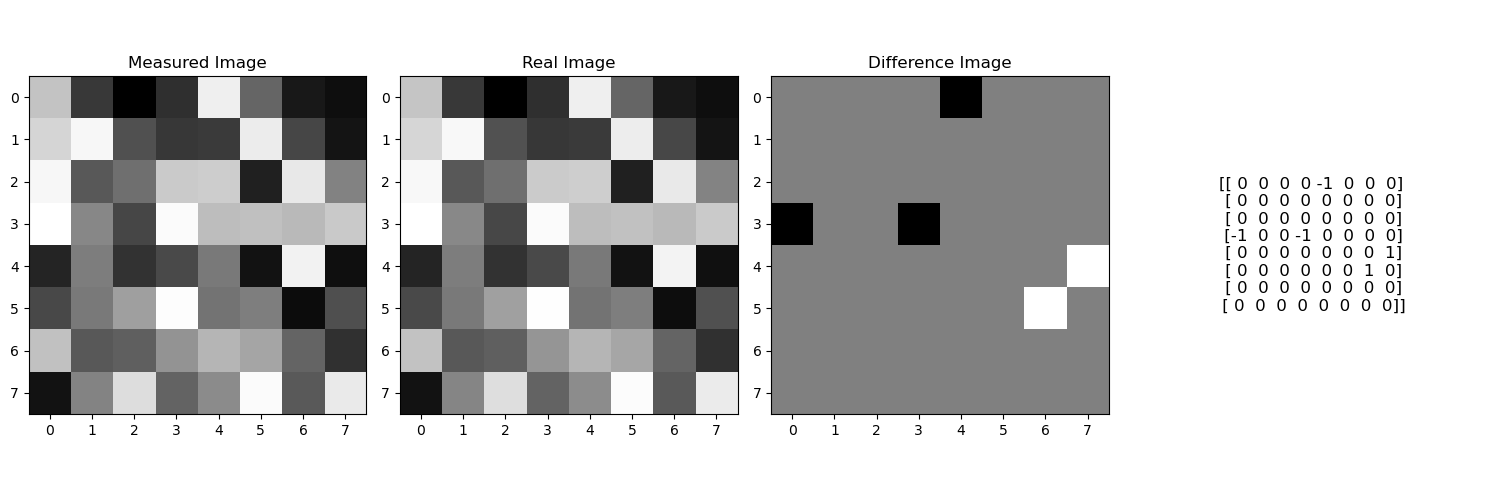

In [171]:
plot_to_compare(output_im, image)

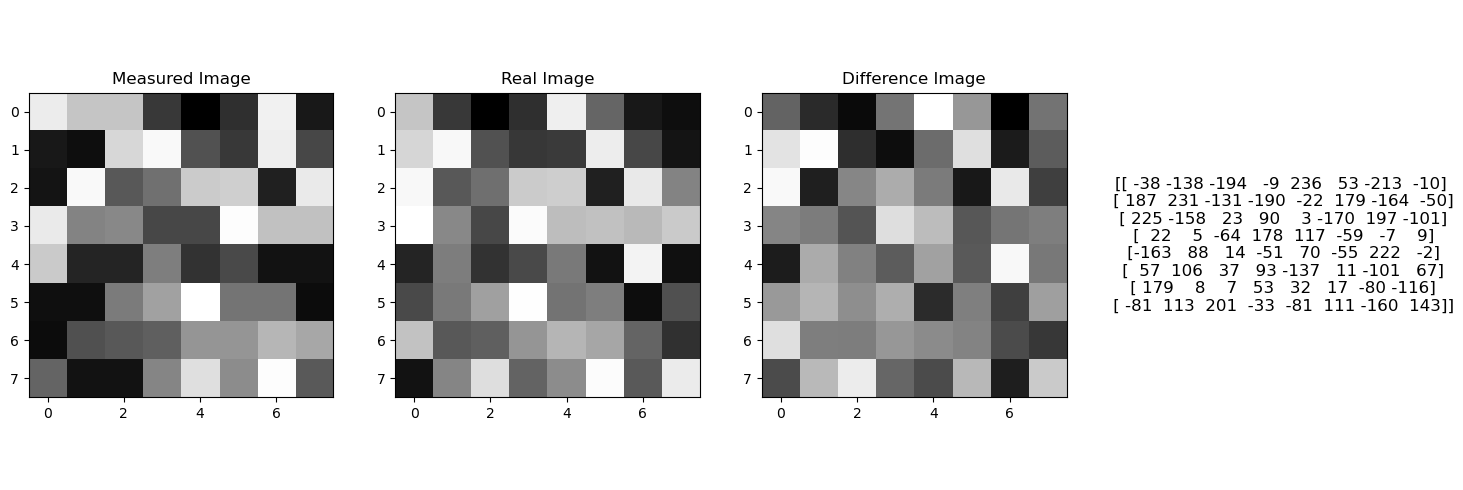

In [172]:
plot_to_compare(output_im_w_coords, image)

As we can see, the first image is nearly identical as the original one, this is because we have increased the number of shots during this circuit.

Regarding the second example, we can clearly see that the real values are much farther off compared to the first example. This is because quantum noise affected both the coordinates and the color equally. However, as I mentioned before, this method of retrieving an image is generally more oriented towards compression. It generates the outcome by using the main characteristics of the image and generalizing the color.

<div style="border-top: 2px dashed black;"></div>

## [OQIM](https://link.springer.com/article/10.1007/s11128-019-2463-7) - Order-encoded quantum image model 

It uses the different basis states of the qubits to perform an intensity sorting, ordering the values according to the gray value of the pixel. Then, a single qubit to store the intensity and the coordinate value of the pixel, and an additional qubit to control the mode of representation(coordinate or intensity).

### Image generation

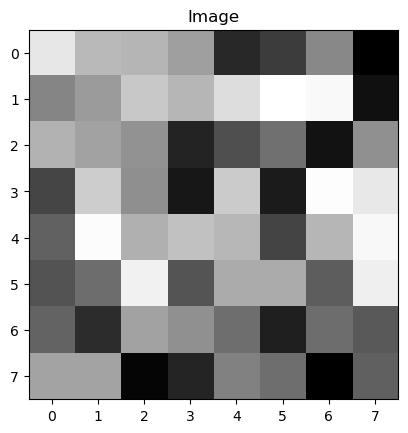

In [173]:
image = image_generate("normal")
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

In [174]:
im_list = image.flatten()
thetas = np.interp(im_list, (0, 256), (0, np.pi/2)) # intensity matrix
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2)) # coordinate matrix

### Qubit calculation

In [175]:
num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1
print(num_ind_bits)

6


### Quantum circuit building

In [176]:
O = QuantumRegister(num_ind_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

In [177]:
qc = QuantumCircuit(c, p, O, cr)
num_qubits = qc.num_qubits
input_im = image.copy().flatten()
qc.i(c)
qc.h(O)
qc.h(p)

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_15108\1327186723.py:4: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use QuantumCircuit.id as direct replacement.
  qc.i(c)


In [178]:
controls = []
for i, _ in enumerate(O):
    controls.extend([O[i]])
for i, _ in enumerate(p):
    controls.extend([p[i]])

In [179]:
for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc.x(O[k])
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc.mcry(theta=2*theta,
                          q_controls=controls,
                          q_target=c[0])
        else:
            qc.x(p)
            qc.mcry(theta=2*phi,
                          q_controls=controls,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc.x(p)
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc.x(O[k])
           
qc.measure(list(reversed(range(qc.num_qubits))), list(range(cr.size)))

In [180]:
print("depth is {}, # of qubits is {}".format(qc.depth(), qc.num_qubits))

depth is 1058, # of qubits is 8


In [181]:
# qc.draw()

### Backend simulation

In [182]:
shots = 100000
backend = Aer.get_backend('aer_simulator')
result, counts = backend_sim(qc, backend, shots)

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_15108\1756418184.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)


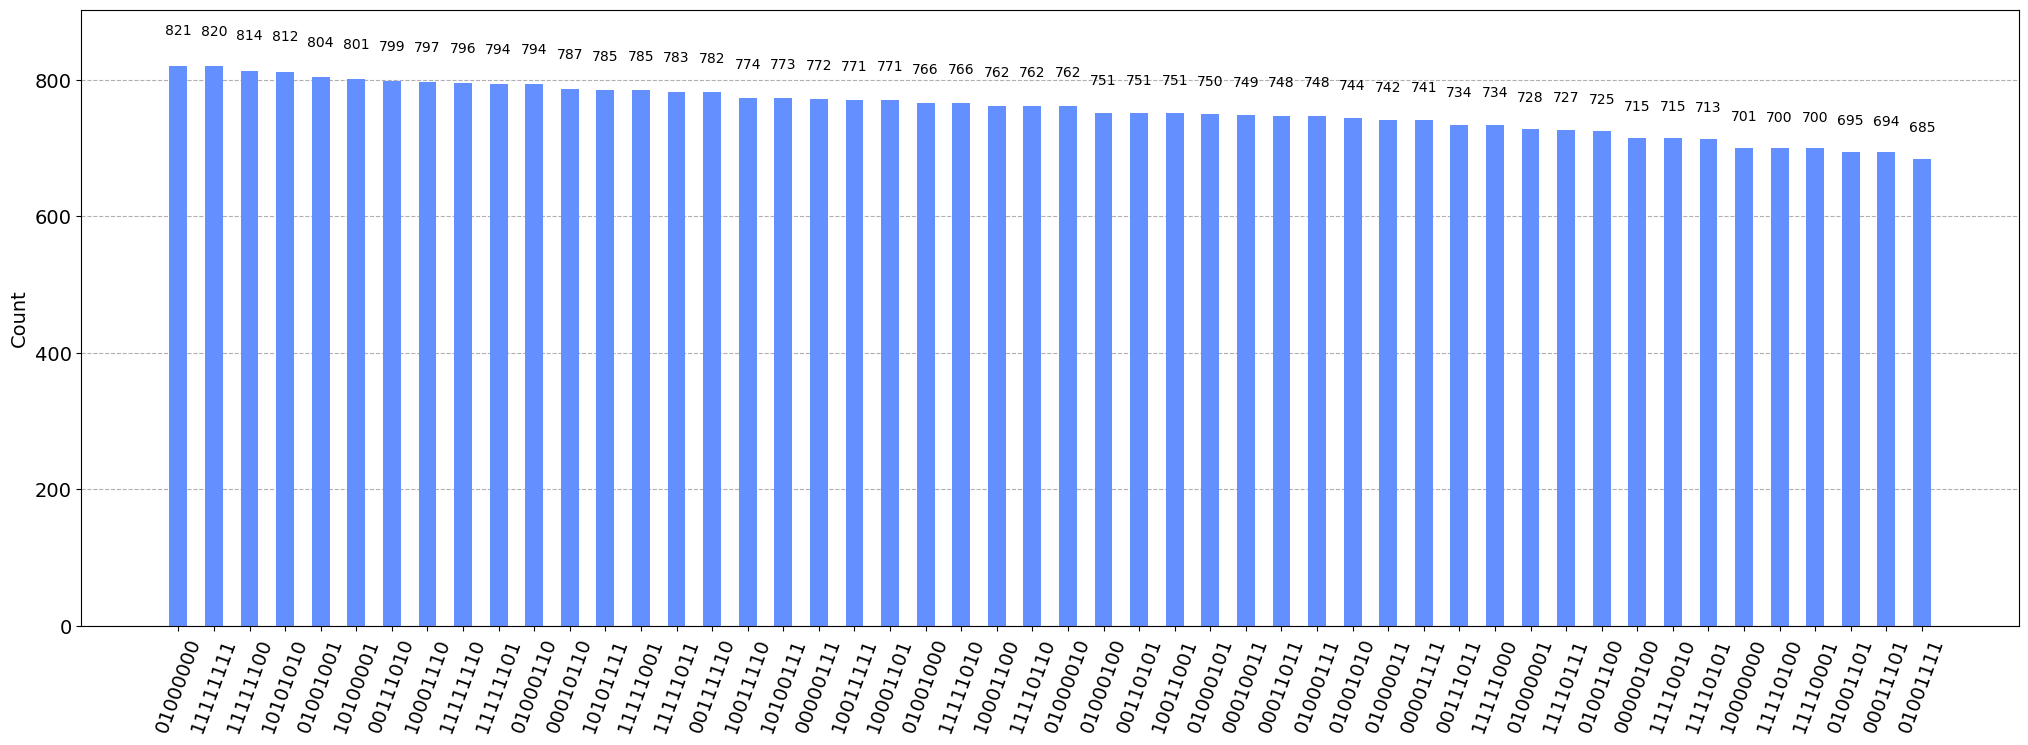

In [183]:
plot_histogram(counts, figsize=(25,8), sort="value_desc", number_to_keep=50)

### Results treatment

In [192]:
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)

In [185]:
classical_colors = []
classical_coords = []
for i in range(0, max_index+1):
    color_list = []
    coord_list = []
    for item in counts.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[2:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            if not int(key[1]): # only difference
                color_list.append((key[0], amount))
            else:
                coord_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
    coord_amount = 0
    for coord, amount in coord_list:
        if not int(coord):
            coord_amount=coord_amount+amount
    try:
        coord = np.arccos((coord_amount/sum(n for _, n in coord_list))**(1/2))
        classical_coords.append(coord)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)
classical_coords = np.interp(classical_coords, (0, np.pi/2), (0, len(im_list))).astype(int)
output_im = classical_colors.reshape(image.shape)

In [186]:
output_im_w_coords = []
for i, item in enumerate(classical_coords):
    output_im_w_coords.append(classical_colors[item - 1])
output_im_w_coords = np.array(output_im_w_coords).reshape(image.shape)

### Input and measured images comparison

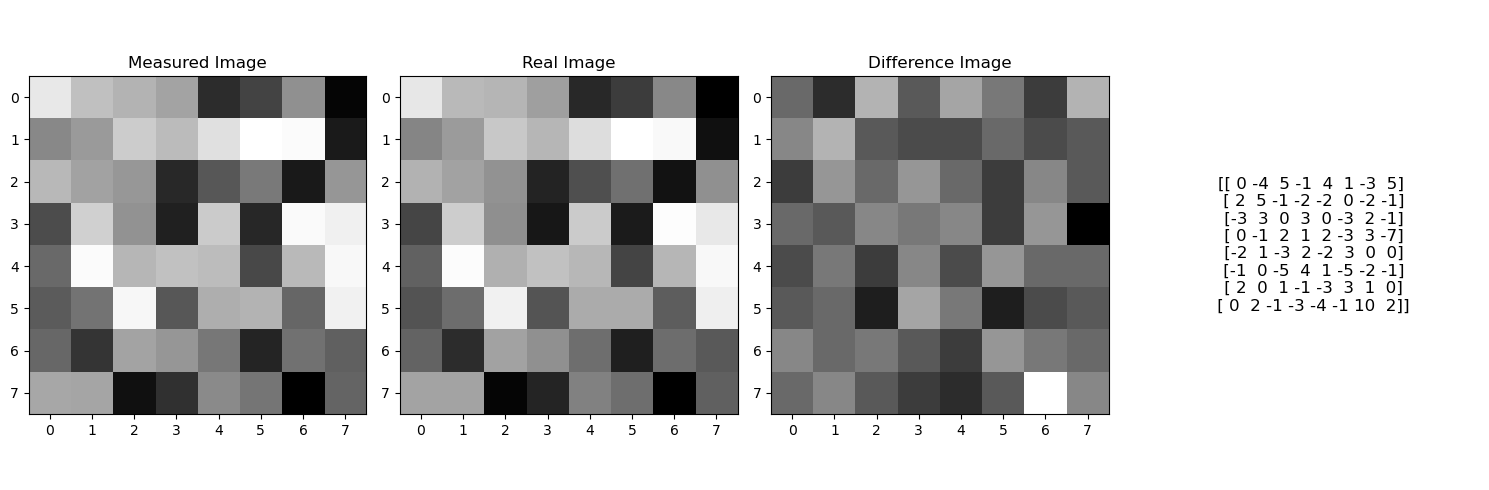

In [187]:
plot_to_compare(output_im, image)

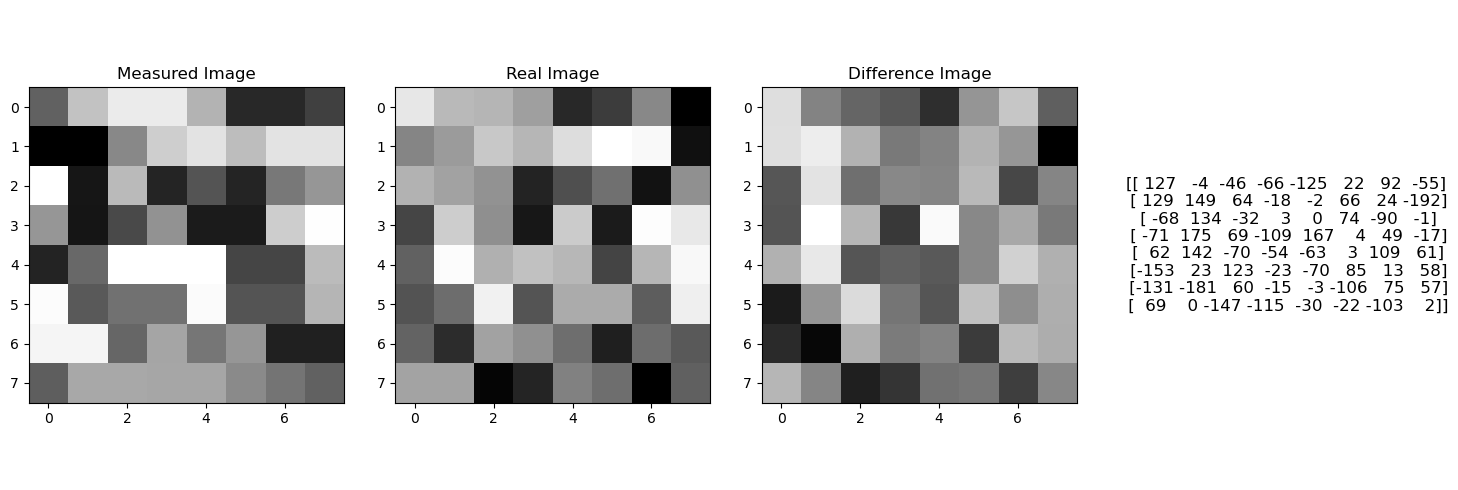

In [188]:
plot_to_compare(output_im_w_coords, image)

<hr style="border: 2px solid black;">

# Discrete representation examples

## [NEQR] - Novel enhanced quantum representation of digital images

$| I \rangle = \frac{1}{2^n}\sum_{Y=0}^{2^n-1}\sum_{X=0}^{2^n-1}\bigotimes_{i=0}^{q-1} | C_{YX}^{i}\rangle | YX \rangle$, where

$| C_{YX}^{i}\rangle$ and $| YX \rangle$ are pixel intensity and coordinate expansion respectively

### Image generation

In [ ]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

### Quantum circuit building

In [ ]:
indx = QuantumRegister(w_bits+h_bits, 'indx')
intensity = QuantumRegister(8,'intensity')
cr = ClassicalRegister(len(indx)+len(intensity), 'cr')
qc_image = QuantumCircuit(intensity, indx, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(intensity)
qc_image.h(indx)
for i, pixel in enumerate(input_im):
    pixel_bin = "{0:b}".format(pixel).zfill(len(intensity))
    position = "{0:b}".format(i).zfill(len(indx))
    for j, coord in enumerate(position):
        if int(coord):
            qc_image.x(qc_image.num_qubits-j-1)
    for idx, px_value in enumerate(pixel_bin[::-1]):
        if(px_value=='1'):
            control_qubits = list(range(intensity.size, intensity.size + indx.size))
            target_qubit = intensity[idx]
            qc_image.mcx(control_qubits, target_qubit)
    if i!=len(input_im) - 1:
        for j, coord in enumerate(position):
            if int(coord):
                qc_image.x(qc_image.num_qubits-j-1)
    qc_image.barrier()
qc_image.measure(range(qc_image.num_qubits),range(cr.size))

In [ ]:
print("depth is {}, # of qubits is {}".format(qc_image.depth(), qc_image.num_qubits))

In [ ]:
wash_qc = transpile(circuits=qc_image, coupling_map=list(coupling_map)[0], basis_gates=basis_gates)
print("depth is {}".format(wash_qc.depth()))

In [ ]:
# qc_image.draw()

### Backend simulation

In [ ]:
shots = 8192
backend = Aer.get_backend('aer_simulator')
result, counts = backend_sim(qc_image, backend, shots)

### Input and measured images comparison

In [ ]:
out_pixels = []
for item in counts:
    out_pixels.append((int(item[0:w_bits+h_bits], 2), int(item[w_bits+h_bits:],2)))
out_image = np.zeros((1, len(input_im)))
for pixel in out_pixels:
    out_image[0][pixel[0]] = pixel[1]
out_image = np.reshape(out_image, (image.shape))
plot_to_compare(out_image, image)

## [BRQI](https://www.overleaf.com/project/61911febed45e965f929d7c0#cite.li2018quantum) - Quantum image representation based on bitplanes

Image is assumed a collection of bitbpanes. Each image has 8 separate bitplanes (in a gray-scaled case). Every bitplane is discribed as follows:

$| \Psi_m^j \rangle = \frac{1}{2^n}\sum_{x=0}^{2^{n-k}-1}\sum_{y=0}^{2^k-1} | g(x,y) \rangle |x \rangle | y \rangle$, where

$\Psi_m^j$ - bitplane representation;

$j = (0,... 7)$ - number of bitplane;

$m = 1$ (in gray scaled case) - band number;

$g(x,y) = (0,1)$ - pre-/absence if $j^{th}$ bitplane in the band $m$

### Image generation

In [ ]:
image = image_generate("smallest")
plt.imshow(image, cmap = 'gray')
plt.show()

In [ ]:
w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1
color_n_b = 8
color_n_b = int(np.ceil(math.log(color_n_b,2)))

### Quantum circuit building

In [ ]:
color = QuantumRegister(1, 'color')
y_ax = QuantumRegister(w_bits, 'y axis')
x_ax = QuantumRegister(h_bits, 'x axis')
bitplane_q = QuantumRegister(color_n_b, 'bitplanes')
classic = ClassicalRegister(1+w_bits+h_bits+color_n_b, 'classic')
qc = QuantumCircuit(color, y_ax, x_ax, bitplane_q, classic)

qc.i(color)
qc.h(x_ax)
qc.h(y_ax)
qc.h(bitplane_q)

qc.barrier()

for bitplane in range(8):
    bit_bitplane = "{0:b}".format(bitplane).zfill(color_n_b)
    for n, bit in enumerate(bit_bitplane):
        if bit!='1':
            qc.x(bitplane_q[n])
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel = "{0:b}".format(image[i,j]).zfill(8)
            if pixel[bitplane]=='1':
                i_bit = "{0:b}".format(i).zfill(h_bits)
                for i_n, ibit in enumerate(i_bit):
                    if ibit!='1':
                        qc.x(x_ax[i_n])
                    j_bit = "{0:b}".format(j).zfill(w_bits)
                for j_n, jbit in enumerate(j_bit):
                    if jbit!='1':
                        qc.x(y_ax[j_n])
                qc.barrier()

                controls = list(range(color.size,
                                      qc.num_qubits))
                xg = XGate(None).control(len(controls))
                controls.append(color)
                qc.append(xg, controls)

                for j_n, jbit in enumerate(j_bit):
                    if jbit!='1':
                        qc.x(y_ax[j_n])

                for i_n, ibit in enumerate(i_bit):
                        if ibit!='1':
                            qc.x(x_ax[i_n])
                qc.barrier()

    for n, bit in enumerate(bit_bitplane):
        if bit!='1':
            qc.x(bitplane_q[n])
qc.barrier()
qc.measure(list(reversed(range(qc.num_qubits))), list(range(classic.size)))

In [ ]:
wash_qc = transpile(circuits=qc, coupling_map=list(coupling_map)[0], basis_gates=basis_gates)#, optimization_level=2)
print("depth is {}".format(wash_qc.depth()))

In [ ]:
print("depth is {}, # of qubits is {}".format(qc.depth(), qc.num_qubits))

### Backend simulation

In [ ]:
shots = 1000000
backend = Aer.get_backend('aer_simulator')
result, counts = backend_sim(qc_image, backend, shots)

### Input and measured images comparison

In [ ]:
out_pixels = []
for item in counts:
    out_pixels.append((int(item[0:color.size], 2),
                       int(item[color.size:color.size+x_ax.size],2),
                       int(item[color.size+x_ax.size:color.size+x_ax.size+y_ax.size],2),
                       int(item[color.size+x_ax.size+y_ax.size:qc.num_qubits],2)
                     ))
out_image = []
for k in range(image.shape[0]):
    for j in range(image.shape[1]):
        bits = [i for i in range(len(out_pixels)) if out_pixels[i][1] == k and out_pixels[i][2] == j]
        pixel = np.zeros((8,))
        for bit in bits:
            pixel[out_pixels[bit][3]] = int(out_pixels[bit][0])
        mystring = "".join([str(int(a)) for a in pixel])
        out_image.append(int(mystring, 2))
out_image = np.array(out_image).reshape(image.shape[1], image.shape[0])
plot_to_compare(out_image, image)

## GQIR 

### Image generation

In [ ]:
image = np.random.uniform(low=0, high=255, size=(1,3)).astype(int)
plt.imshow(image, cmap = 'gray')

### Quantum circuit building

In [ ]:
x = int(np.ceil(math.log(image.shape[0], 2)))
if int(x) == 0: x = 1
y = int(np.ceil(math.log(image.shape[1], 2)))
if int(y) == 0: y = 1
q = 8

color = QuantumRegister(q, 'color')
y_ax = QuantumRegister(y, 'y axis')
x_ax = QuantumRegister(x, 'x axis')
classic = ClassicalRegister(x+y+q, 'classic')
qc = QuantumCircuit(color, y_ax, x_ax, classic)

qc.i(color)
qc.h(x_ax)
qc.h(y_ax)
qc.barrier()
controls_ = []
for i, _ in enumerate(x_ax):
    controls_.extend([x_ax[i]])
for i, _ in enumerate(y_ax):
    controls_.extend([y_ax[i]])  
for xi in range(image.shape[0]):
    xi_bin = "{0:b}".format(xi).zfill(x_ax.size)
    for i, bit in enumerate(xi_bin):
        if not int(bit):
            qc.x(x_ax[i])  
    qc.barrier()
    for yi in range(image.shape[1]):
        yi_bin = "{0:b}".format(yi).zfill(y_ax.size)
        for i, bit in enumerate(yi_bin):
            if not int(bit):
                qc.x(y_ax[i]) 
        qc.barrier()
        intensity_bin = "{0:b}".format(image[xi, yi]).zfill(len(color))
        xg = XGate(None).control(len(controls_))
        target = []
        for i, bit in enumerate(intensity_bin):
            if int(bit):
                qc.mcx(controls_, color[i])
        qc.barrier()
        for i, bit in enumerate(yi_bin):
            if not int(bit):
                qc.x(y_ax[i])
        qc.barrier()
    for i, bit in enumerate(xi_bin):
        if not int(bit):
            qc.x(x_ax[i])
    qc.barrier()

qc.measure(x_ax, range(x_ax.size))
qc.measure(y_ax, range(x_ax.size, x_ax.size+y_ax.size))
qc.measure(color, range(x_ax.size+y_ax.size,x_ax.size+y_ax.size+color.size))

In [ ]:
print("depth is {}, # of qubits is {}".format(qc.depth(), qc.num_qubits))

In [ ]:
wash_qc = transpile(circuits=qc, coupling_map=list(coupling_map)[0], basis_gates=basis_gates)
print("depth is {}".format(wash_qc.depth()))

### Backend simulation

In [ ]:
shots = 80000
backend = Aer.get_backend('aer_simulator')
result, counts = backend_sim(qc_image, backend, shots)
counts = (["".join(list(reversed(c))) for c in counts])

### Input and measured images comparison

In [ ]:
out_pixels = []
for item in counts:
    out_pixels.append((int(item[0:x], 2), int(item[x:x+y],2), int(item[-q:],2)))
out_image = np.zeros(image.shape)
for pixel in out_pixels:
    if pixel[0]<out_image.shape[0]:
        if pixel[1]<out_image.shape[1]:
            out_image[pixel[0], pixel[1]] = pixel[2]
plot_to_compare(out_image, image)